<div style="font-size: 18px;">
PLEASE READ BEFORE USING THIS CODE
</div>
<br>

<div style="font-size: 16px;">
This is (hopefully) pretty easy to use, but requires some interaction to make fully accurate plots.<br>
After updating the variables in the cell following the imports, you should be able to 'run all' to see plots good enough for "at a glance" analysis. If you are just working through lots of data and want to get a general idea of the model-data flux ratio, this should be good enough, and you can stop reading.

However, if you are trying to create *publishable* polka dot plots, you'll need to do some extra work. The polka dot code works by using emission and continuum boundaries defined in the imported .txt file. These boundaries aren't perfectly preserved between each observation, and therefore need to be manually visually vetted and updated for each obsID in order to be fully accurate.
    
If that's the goal, inspect the full spectra and individual emission line plots to determine which lines have distinguishable emission in this observation. Create your own .txt file with absent lines removed, thereby ensuring the code doesn't create dots for what is essentially continuum. If there is a line absent from HEG but not MEG, set all its boundaries to zero. If you flat out delete it, the code will get confused because MEG and HEG have a different number of lines.  <br>
Then, once again inspect the individual emission line plots, looking for two things:<br>
&emsp;1. Overly slanted continuum fits. <br>
&emsp;&emsp;This occurs when the continuum boundaries (vertical green lines) fall on some emission. Change the values in the<br>&emsp;&emsp;6th and 7th (MEG), or 10th and 11th (HEG) column of numbers in the .txt file until the continuum boundary is accurate. This can require<br>&emsp;&emsp;some trial and error to get right, as the code selects the boundary as the first data point to the left of the number given,<br>&emsp;&emsp;not the actual number.<br>
&emsp;2. Inaccurate emission borders (vertical black lines). <br>
&emsp;&emsp;Emission is inherently a little different spectra-to-spectra. You have to tell the code where exactly the emission starts<br>&emsp;&emsp;and ends. Do this by adjusting the values in the 4th and 5th (MEG) or 8th and 9th (HEG) column of numbers in the .txt file. It will<br>&emsp;&emsp;use the actual values you input, so it should be much less finicky than the continuum boundaries.
    
With your new .txt file, the dots should now be fully accurate to your data. Congrats!<br>
    -Isaac Levenstein (2025)
</div>

In [166]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
from matplotlib.ticker import MaxNLocator
#text settings
params ={'mathtext.default':'regular'}          
plt.rcParams.update(params)
tnr="Times New Roman"
tnrb="Times New Roman Bold"

In [167]:
#Here we define all manually named variables you will need to call later

#FILES
filename = "TESTdat_chandra.dat"
 
lines = "zpup_lines.txt"

#PLOT TEXT
dataset = 'chandra' #should either be 'chandra' or 'xmm'
exposure = 67740

obsID = 'TEST'
binsize = 'test binsize'
heii = 'test HeII'
abundance = 'test abundances'

#PARAMETERS - only need to be updated if making a final figure.
params = 'false' #make = 'true' or 'false' to turn parameter display on/off

kT = "0.110, 0.187, 0.318,\n0.540, 0.919, 1.56"
norms = "0, 5410, 614, 238, 33.2, 17.6"
vel = "746.676"
z = r'${-1.57\times10^{-3}}$'
sigma_star = r'${5.89\times10^{-2}}$'

total_bins = "113"
c_stat = "167.74"

#SAVE FILE NAMES
spec1dot_name = "TEST_MEGdots.png"
spec2dot_name = "TEST_HEGdots.png"
dot_name = "TEST_dots.png"

spectra1_name = "TEST_MEGspectra.jpg"
spectra2_name = "TEST_HEGspectra.jpg"

#OTHER PLOT TEXT (only needs to be changed if not working on zeta pup / Chandra or XMM data)
starname='$\\zeta$ Pup'
starnum=0 #for now, need this (zeta Pup designation) to make some of W's functions work
star='zpup'
if dataset == 'chandra':
    spec1 = 'MEG'
    spec2 = 'HEG'
elif dataset == 'xmm':
    spec1 = 'RGS1'
    spec2 = 'RGS2'

In [168]:
#defining some functions to use later
def read_dat_file(filename):
    """
    Specialized function for reading .dat files and outputting a 3-tiered
    list (described below).
    """
    datfile = open(filename, "r")
    line = datfile.readline().strip()
    
    #skipping header
    while line[0] not in "0123456789":
        line = datfile.readline().strip()
    
    """
    a 2-tiered list:
    tier 1: the data set (MEG/RGS1 or HEG/RGS2)
    tier 2: 0   central wavelength in angstroms
            1   half-width of bin
            2   data value, in counts/sec/angstrom
            3   formal uncertainty, same units
            4   model 
    """
    
    data = []
    eg = [[],[],[],[],[]] #to hold spectra 1, then spectra 2, as we go through appending
    while line != "": #until end of file, keep reading

#if we find a divider (the NO NO NO NO NO line), then append spectra 1 data to data list and reset eg
#to hold spectra 2 data
        if line[0] == "N":
            data.append(eg)
            eg = [[],[],[],[],[]]
        
        else:
            line = line.split(" ") #otherwise, split line into list of strings
            eg[0].append(float(line[0])) #append float of wavelength to wavelength list
            eg[1].append(float(line[1])) #append half bin width
            eg[2].append(float(line[2])) #append data value
            eg[3].append(float(line[3])) #append error bar value
            eg[4].append(float(line[4])) #append model value

        
        #grab the next line
        line = datfile.readline().strip()
    
    #at end of file, append HEG data to data list
    data.append(eg)

    if data[0][0][0] > data[0][0][1]: #if spectra 1 data in order of decreasing wavelength
        for i in range(5):
            data[0][i].reverse() #reverse order
    if data[1][0][0] > data[1][0][1]: #if spectra 2 data in order of decreasing wavelength
        for i in range(5):
            data[1][i].reverse() #reverse order
    return data

def histogram_data(data):
    """
    Takes a data set and returns a data set that will produce a histogram.
    This involves, essentially, doubling the size of the model. Instead
    of plotting each value once at the center of the bin, we want to plot
    twice on either side of the bin.
    """
    #each of these has two parts: one for the first data set,
    #one for the second
    histwvs = [[],[]]
    histmods = [[],[]]
    histvals = [[],[]]
    
    for i in range(len(data)):
        for j in range(len(data[i][1])):
            histwvs[i].append(data[i][0][j]-data[i][1][j]) #append left wavelength of bin
            histwvs[i].append(data[i][0][j]+data[i][1][j]) #append right wavelength of bin
            histvals[i].append(data[i][2][j]) #append data value twice. This actually isn't necessary for any of these
            #plots, so you can delete it if you want.
            histvals[i].append(data[i][2][j])
            histmods[i].append(data[i][4][j]) #append model value twice
            histmods[i].append(data[i][4][j])
    return histwvs,histvals,histmods

#Poisson errors, to replace default xspec errors
def poisson_error(data,exposure_time):
    poisson_errs = [[],[]]

    for i in range(len(data)):
        for j in range(len(data[i][0])):
            count=data[i][2][j]*exposure_time*2*data[i][1][j]
            if count < 0:
                count = 0
            one_err=(count**0.5)/(exposure_time*2*data[i][1][j])
            poisson_errs[i].append(one_err)

    return poisson_errs

In [169]:
#reading data
data = read_dat_file(filename)
histwvs,histvals,histmods = histogram_data(data)

spec1_wvs = data[0][0]
spec1_bins = data[0][1]
spec1_vals = data[0][2]
spec1_errs = data[0][3]
spec1_mods = data[0][4]
spec1_poisson = poisson_error(data,exposure)[0]
    
spec2_wvs = data[1][0]
spec2_bins = data[1][1]
spec2_vals = data[1][2]
spec2_errs = data[1][3]
spec2_mods = data[1][4]
spec2_poisson = poisson_error(data,exposure)[1]

#lines names, centers, and temps
ll_filename =lines
line_names = np.loadtxt(ll_filename, dtype=type(""),usecols=(0)) #load line names into list
line_locs = np.loadtxt(ll_filename,usecols=(1)) #load line locations into list
line_temps = np.loadtxt(ll_filename, usecols=(2)) #load line temps into list. Temps are in Kelvin, not keV

#MEG boundaries
mline_locations = np.loadtxt(ll_filename, usecols=(3,4)) #load line wavelengths into list
m_cls = np.loadtxt(ll_filename, usecols=(5,6)) #load continuum boundaries into list

#HEG boundaries
hline_locations= np.loadtxt(ll_filename, usecols=(7,8))
h_cls = np.loadtxt(ll_filename, usecols=(9,10)) #load continuum boundaries into list

#combining MEG and HEG
cont_locations=[m_cls,h_cls]
line_locations=[mline_locations,hline_locations]

In [170]:
#Functions that will calculate numbers needed for the ratios we're plotting

def integrate_continuum(data, dnum, xmin, xmax, cnmin, cnmax,xnmin,xnmax):
    """
    Returns parameters for continuum's slope-intercept form (y=mx+b) and 
    the integrated total under the continuum for both the data and model.
    Parameters passed in are:
    <data>: the 3-tier data structure
    <dnum>: the data set number (first index of 3-tier structure)
    <xmin> & <xmax>: the range of the line given in the line list file
    <cnmin> & <cnmax>: the indices for the short- and long-wavelength bins
        nearest to the line that are entirely in the continuum
    <xnmin> & <xnmax>: must be parameters I used previously. It should be okay to remove them.
    """   
                
    #the appropriate values to find our m and b values for a linear continuum fit

    x1 = data[dnum][0][cnmin]
    x2 = data[dnum][0][cnmax]
    y1dat = data[dnum][2][cnmin]
    y2dat = data[dnum][2][cnmax]
    y1mod = data[dnum][4][cnmin]
    y2mod = data[dnum][4][cnmax]
    
    mdat = (y2dat - y1dat) / (x2 - x1)
    bdat = -mdat * x1 + y1dat
    mmod = (y2mod - y1mod) / (x2 - x1)
    bmod = -mmod * x1 + y1mod
    
    int_cont_dat=(.5*mdat*(xmax**2)+bdat*xmax)-(.5*mdat*(xmin**2)+bdat*xmin) #integrated area under data continuum
    int_cont_mod=(.5*mmod*(xmax**2)+bmod*xmax)-(.5*mmod*(xmin**2)+bmod*xmin) #integrated area under model continuum
    
    return (mdat, bdat, int_cont_dat), (mmod, bmod, int_cont_mod)

def find_cont(data, dnum, umin, umax):
    """
    Returns the indices of the bins for the short- and long-wavelength bins
        nearest to the line in question that are entirely in the continuum
    Parameters:
    <data>: the 3-tier data structure
    <dnum>: the data set number (first index of 3-tier structure)
    <xmin> & <xmax>: the range of the line given in the line list file
    If we run into any issues (like the line not existing in this dataset),
        null values are returned.
    """
    cdata = data[dnum] #cdata for current data (i.e. MEG or HEG)
    d_len = len(cdata[0]) #to avoid index errors
    
    n1 = 0
    found1 = False
    while not found1 and n1 < d_len: #index through to find bin just before left range of line
        if cdata[0][n1]+cdata[1][n1] < umin: #if not found, move to next bin
            n1+=1 
        else:
            n1-=1 #found bin containing left of line, so subtract 1 from n1 and exit loop
            if n1 < 0:
                return None, None #if left range in first bin of entire dataset, return None
            found1 = True
    
    if n1 == d_len: #if end of data reached, return None
        return None, None
    
    n2 = n1 + 1
    found2 = False
    while not found2 and n2 < d_len: #index through to find bin containing right end of line
        if cdata[0][n2]-cdata[1][n2] < umax: #if not found, move to next bin
            n2+=1 
        else:
            found2 = True #found bin just right of right end, so exit loop
    
    if n2 == d_len: #if end of data reached, return None
        return None, None #this is returning "None" for the later line and makes an error.
    
    return n1, n2

def integrate_line(data, dnum, xmin, xmax, xnmin, xnmax, int_type):
    """
    Integrates (rectangularly) the data or model over the specified line.
    Parameters:
    <data>: the 3-tiered data structure
    <dnum>: the data set number (0 for MEG/RGS1 or 1 for HEG/RGS2)
    <xmin> & <xmax>: the range of the line given in the line list file
    <xnmin> & <xnmax>: the two indices that correspond to bins entirely 
                     outside the line
    <int_type>: whether this should integrate the data or the model
    """
    cdata = data[dnum] #cdata for current data

    if int_type.lower() == "data":
        int_ind = 2
    elif int_type.lower() == "model":
        int_ind = 4
    else:
        raise Exception("Parameter <int_type> must be 'data' or 'model'.")
        
    if xnmin==xnmax: #if xmin and xmax in same bin
        binw=xmax-xmin
        y=cdata[int_ind][xnmin]
        total_int=binw*y

    else:
        #find widths of first and end partial bins as before
        binw_0=cdata[0][xnmin]+cdata[1][xnmin]-xmin
        binw_end=xmax-(cdata[0][xnmax]-cdata[1][xnmax])

        #find model or data yval for each partial bin
        y_0=cdata[int_ind][xnmin]
        y_end=cdata[int_ind][xnmax]

        #multiply yvals by bin widths and add the products to the integral
        total_int=binw_0*y_0+binw_end*y_end
        
        #for all full bins between partial bins
        for i in range(xnmin+1,xnmax):
            #multiply yval by bin width and add to integral
            total_int+=cdata[int_ind][i]*2*cdata[1][i]

    return total_int

def line_ratio(data, dnum, line_names, line_locations, cont_locations):
    """
    Creates <int_tot> to keep track of the information about each line.
    
    Structure of <int_tot>
    0:    line name
    1&2:  xmin & xmax
    3&4:  the continuum-subtracted integrals of the data and model, respectively
    5&6:  the slope and y-intercept, respectively, of the 
          continuum line fitted to the data
    7&8:  the slope and y-intercept, respectively, of the 
          continuum line fitted to the model
    9&10: xnmin & xnmax
    11:   the ratio of data-to-model flux
    12&13:cnmin and cnmax
    """
    int_tot = []

    for i in range(len(line_locations)):
        xmin = line_locations[i][0]
        xmax = line_locations[i][1]
        cmin=cont_locations[i][0]
        cmax=cont_locations[i][1]
        cnmin, cnmax = find_cont(data, dnum, cmin, cmax) #TRACE error
        #print(cnmin)
        #print(cnmax)#used for TROUBLESHOOTING
        xnmin,xnmax=find_cont(data,dnum,xmin,xmax)
        if xnmin == None or cnmin == None: #ie if line isn't in dataset
            int_tot.append([line_names[i], xmin, xmax, None, None, None, None, \
                           None, None, None])
        else:
            xnmin+=2
            xnmax-=2
            #integrate continuum
            dat_cont, mod_cont = integrate_continuum(data, dnum, xmin, xmax, \
                                                     cnmin, cnmax,xnmin,xnmax) #TRACE
            #integral of the line is the integral of the data or model minus the appropriate continuum
            dat_line = integrate_line(data, dnum, xmin, xmax, \
                                     xnmin, xnmax, "data") - dat_cont[2]
            mod_line = integrate_line(data, dnum, xmin, xmax, \
                                     xnmin, xnmax, "model") - mod_cont[2]
            #add all the information to <int_tot>
            int_tot.append([line_names[i], xmin, xmax, dat_line, mod_line, \
                           dat_cont[0], dat_cont[1], mod_cont[0], mod_cont[1], \
                           xnmin, xnmax, mod_line/dat_line,cnmin,cnmax])
    return int_tot

In [171]:
ratios=[[],[]]

#for plotting MEG/RGS1 line ratios
int_tot0 = line_ratio(data, 0, line_names, line_locations[0],cont_locations[0])
for i in range(len(int_tot0)):
    if int_tot0[i][3] == None:
        print("%s %s does not appear in dataset." %(spec1, int_tot0[i][0]))
    else:
        print("%s %s: %.3f" %(spec1, int_tot0[i][0], int_tot0[i][11]))
        print("Total counts: %.0f data %.0f model" %(int_tot0[i][3]*68e3,int_tot0[i][4]*68e3))

#for plotting HEG/RGS2 line ratios
int_tot1 = line_ratio(data, 1, line_names, line_locations[1],cont_locations[1])
for i in range(len(int_tot1)):
    if int_tot1[i][3] == None:
        print("%s %s does not appear in dataset." %(spec2, int_tot1[i][0]))
    else:
        print("%s %s: %.3f" %(spec2, int_tot1[i][0], int_tot1[i][11]))
        print("Total counts: %.0f data %.0f model" %(int_tot1[i][3]*68e3,int_tot1[i][4]*68e3))

MEG CVI does not appear in dataset.
MEG NVI does not appear in dataset.
MEG NVI does not appear in dataset.
MEG NVI does not appear in dataset.
MEG NVI does not appear in dataset.
MEG NVII: 1.719
Total counts: 255 data 438 model
MEG OVII: 0.317
Total counts: 216 data 69 model
MEG NVII: 1.572
Total counts: 50 data 78 model
MEG NVII does not appear in dataset.
MEG OVIII: 0.510
Total counts: 199 data 102 model
MEG FeXVII: 2.349
Total counts: 357 data 839 model
MEG FeXVII: 1.377
Total counts: 295 data 407 model
MEG OVIII: 0.891
Total counts: 145 data 129 model
MEG FeXVII: 0.866
Total counts: 472 data 408 model
MEG FeXVII: 1.311
Total counts: 528 data 692 model
MEG FeXVIII: 0.839
Total counts: 93 data 78 model
MEG NeIX: 0.632
Total counts: 1097 data 694 model
MEG NeX: 0.822
Total counts: 678 data 558 model
MEG MgXI: 1.023
Total counts: 1110 data 1135 model
MEG MgXII: 1.051
Total counts: 155 data 162 model
MEG SiXIII: 1.016
Total counts: 943 data 958 model
HEG CVI does not appear in dataset.

In [172]:
#function that will plot each individual line we feed it in the text files

def plot_line(data, dnum, histwvs, histvals, line_pars, datatype,\
              filename=None, yrange=None, fmt=".", alpha=1):
    """
    Takes a particular emission line and plots the continuum fit along w/ data and model so you can make sure
    continuum is reasonable.
    <line_pars> should be the particular element of the <int_tot> list.
    <yrange> should be a list/tuple of (min, max)
    To save the image, use the <filename> parameter.
    """
    plt.rcParams['figure.figsize'] = (35.0, 8.0)
    
    if line_pars[5] ==  None:
        print("%s not found in this dataset." %(line_pars[0]),datatype)
        print("Boundaries of the line:",line_pars[1],line_pars[2])
        #notifying, escaping if the line does not exist
        return
    
    #the edge of the lines given in the .txt file
    xmin = line_pars[1]
    xmax = line_pars[2]
    #DHC - 29jan22 - and the continuum wavelengths
    contmin = data[dnum][0][line_pars[12]]
    contmax = data[dnum][0][line_pars[13]]
#    print(xmin,xmax,contmin,contmax)
    print('\ncontinuum locations =',data[dnum][0][line_pars[12]],data[dnum][0][line_pars[13]])
    #the wavelength location of the plot boundaries
    plot_xmin = data[dnum][0][line_pars[12]] - data[dnum][1][line_pars[12]]
    plot_xmax = data[dnum][0][line_pars[13]] + data[dnum][1][line_pars[13]]
    
    #getting x and y values for points along the linear continuum fit across the spectral line
    data_fit_x = np.linspace(plot_xmin, plot_xmax, 10)
    model_fit_x = data_fit_x
    data_fit_y = s_i(data_fit_x, line_pars[5], line_pars[6])
    model_fit_y = s_i(model_fit_x, line_pars[7], line_pars[8])
    
    #plot the continuum fits
    plt.plot(data_fit_x, data_fit_y, 'r-.', alpha=alpha)
    plt.plot(model_fit_x, model_fit_y, 'b-.', alpha=alpha)
    
    #plot line boundaries
    plt.axvline(xmin, color='k', linestyle='--')
    plt.axvline(xmax, color='k', linestyle='--')
    # plot continuum anchor locations
#    plt.vlines([xmin, xmax], ymin = 0., ymax = 1., linestyle = '--', color = 'cornflowerblue', linewidth = 1)
#    plt.vlines([contmin,contmax], ymin = 0., ymax = 1., linestyle = '--', color = 'plum', linewidth = 1)
    # OR 
    plt.axvline(contmin, color='green', linestyle='--', linewidth=3)
    plt.axvline(contmax, color='green', linestyle='--', linewidth=3)
    #grabbing the appropriate parameters to make the graph
    wavelengths = []
    x_uncertainty = []
    values = []
    y_uncertainty = []

    for i in range(len(data[dnum][0])):
        wavelengths.append(data[dnum][0][i])
        x_uncertainty.append(data[dnum][1][i])
        values.append(data[dnum][2][i])
        y_uncertainty.append(data[dnum][3][i])
        
    #plot data
    plt.errorbar(wavelengths, values, xerr=x_uncertainty, \
                 yerr=y_uncertainty, fmt=fmt, alpha=alpha, color='r')
    #plot model histogram
    plt.plot(histwvs[dnum], histmods[dnum], color='b', alpha=alpha)
    plt.tick_params(labelsize=30)
    
    plt.xlim(plot_xmin, plot_xmax)
    
    if yrange:
        plt.ylim(yrange)
    else:
        #finding the largest data value in the region of the line
        #to fit view roughly to that
        ymax=0.
        for j in range(line_pars[9],line_pars[10]+1):
            if data[dnum][2][j] > ymax:
                ymax = data[dnum][2][j]
            if data[dnum][4][j] > ymax:
                ymax = data[dnum][4][j]
        plt.ylim(-ymax*.2, ymax*1.2)

    plt.grid(visible=True) #LZ: fixed; since Matplotlib3.5, the parameter 'b' to display gridlines have been changed to 'visible'.
    plt.xlabel("Wavelength (Å)", fontsize=30, fontname=tnr)
    plt.ylabel("Counts/s/Å", fontsize=30,fontname=tnr)
    plt.xticks(fontname=tnr)
    plt.yticks(fontname=tnr)
    plt.suptitle(datatype+"  %s: %.3f" %(line_pars[0], line_pars[11]),fontsize=30, fontname=tnr, x=.5,y=1)
    plt.tight_layout(pad=0)
    
    if filename:
        #plt.savefig("zpup_temp_"+filename)
        print("image not saved")
    plt.show()
    
def s_i(x, m, b):
    #returns the y-value of a line in slope-intercept form
    return m*x + b

CVI not found in this dataset. MEG
Boundaries of the line: 0.0 0.0
CVI not found in this dataset. HEG
Boundaries of the line: 0.0 0.0
NVI not found in this dataset. MEG
Boundaries of the line: 0.0 0.0
NVI not found in this dataset. HEG
Boundaries of the line: 0.0 0.0
NVI not found in this dataset. MEG
Boundaries of the line: 0.0 0.0
NVI not found in this dataset. HEG
Boundaries of the line: 0.0 0.0
NVI not found in this dataset. MEG
Boundaries of the line: 28.5 29.8
NVI not found in this dataset. HEG
Boundaries of the line: 28.5 29.8
NVI not found in this dataset. MEG
Boundaries of the line: 0.0 0.0
NVI not found in this dataset. HEG
Boundaries of the line: 0.0 0.0

continuum locations = 23.880003 25.6250019


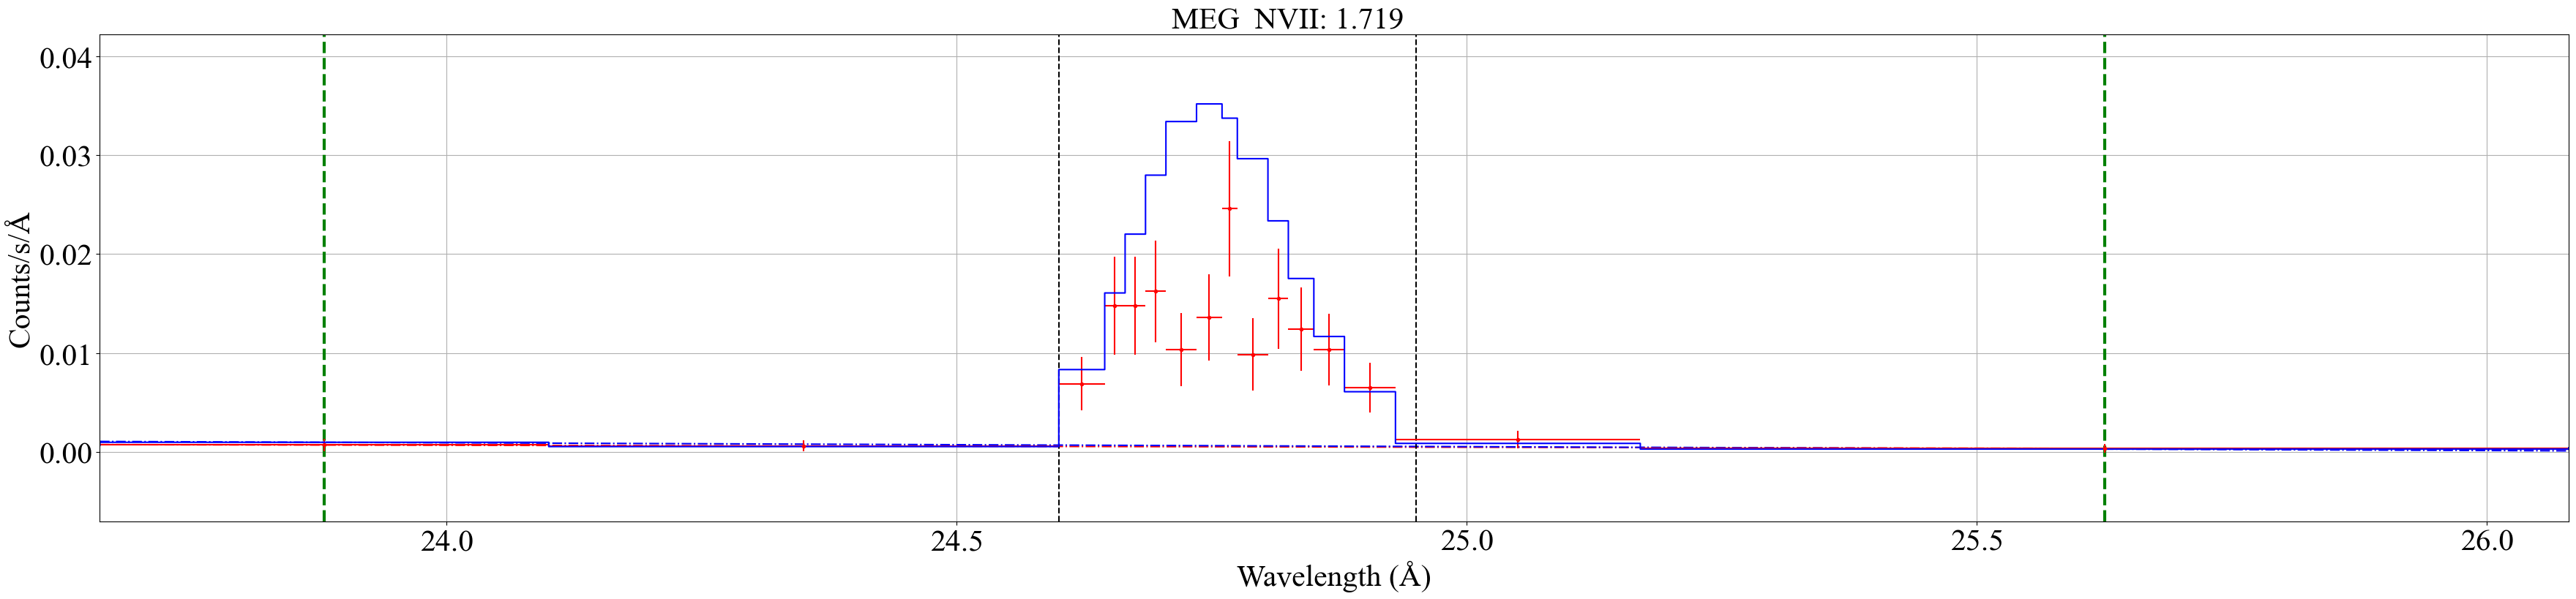

NVII not found in this dataset. HEG
Boundaries of the line: 24.5 25.0

continuum locations = 20.1400032 23.4275017


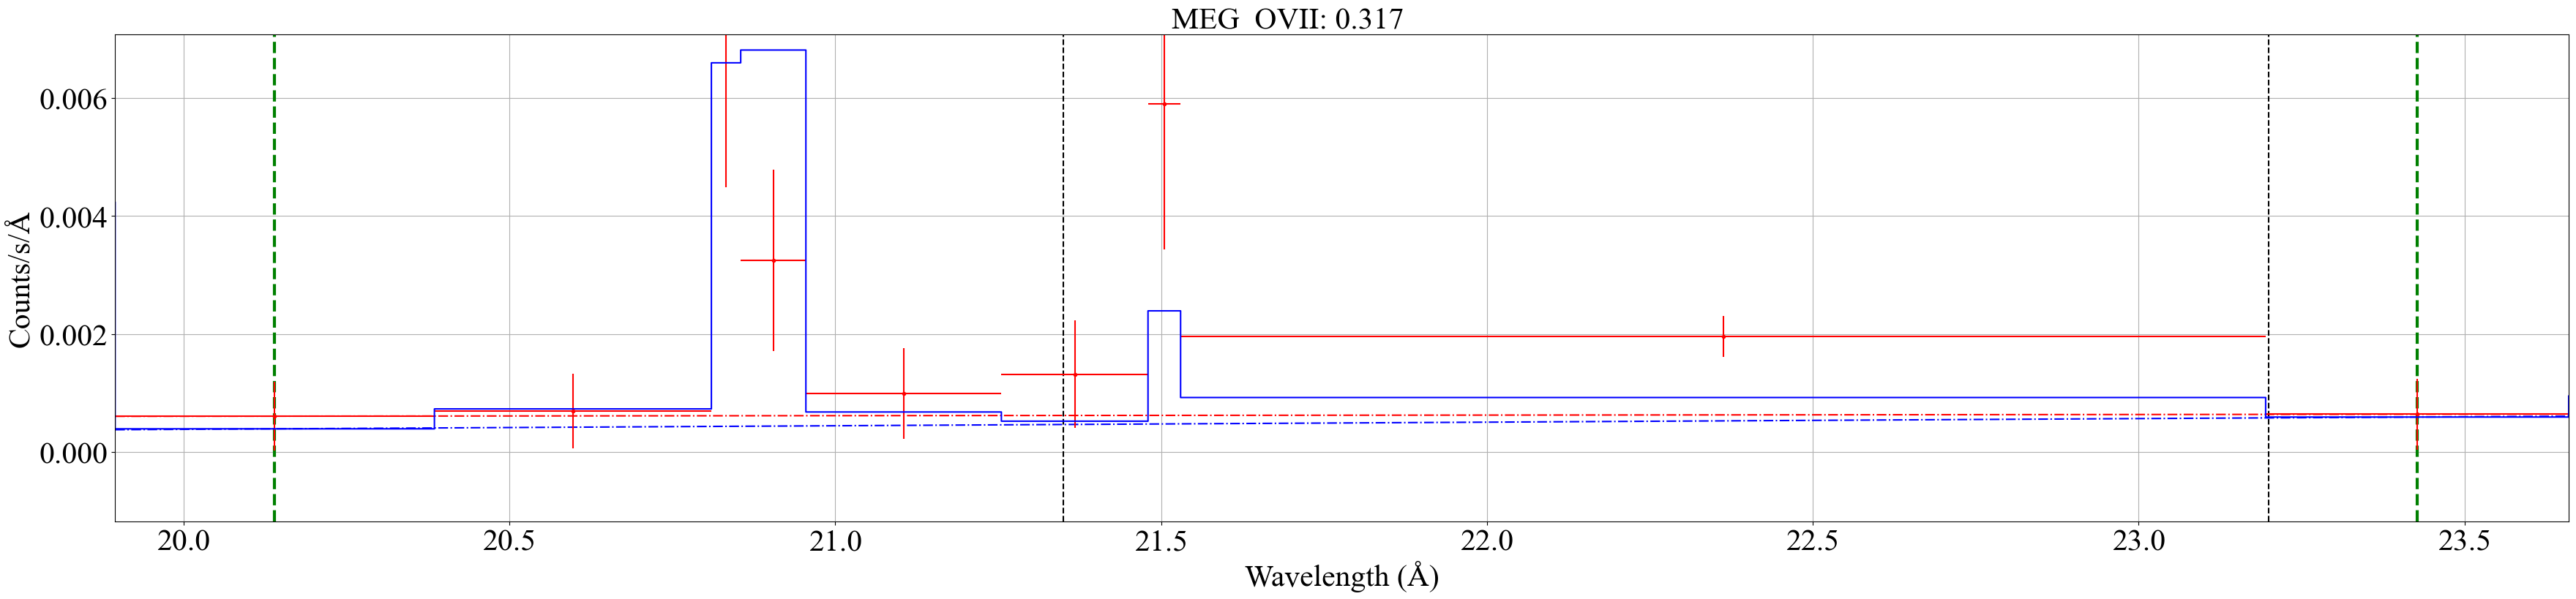

OVII not found in this dataset. HEG
Boundaries of the line: 21.5 21.7

continuum locations = 20.1400032 23.4275017


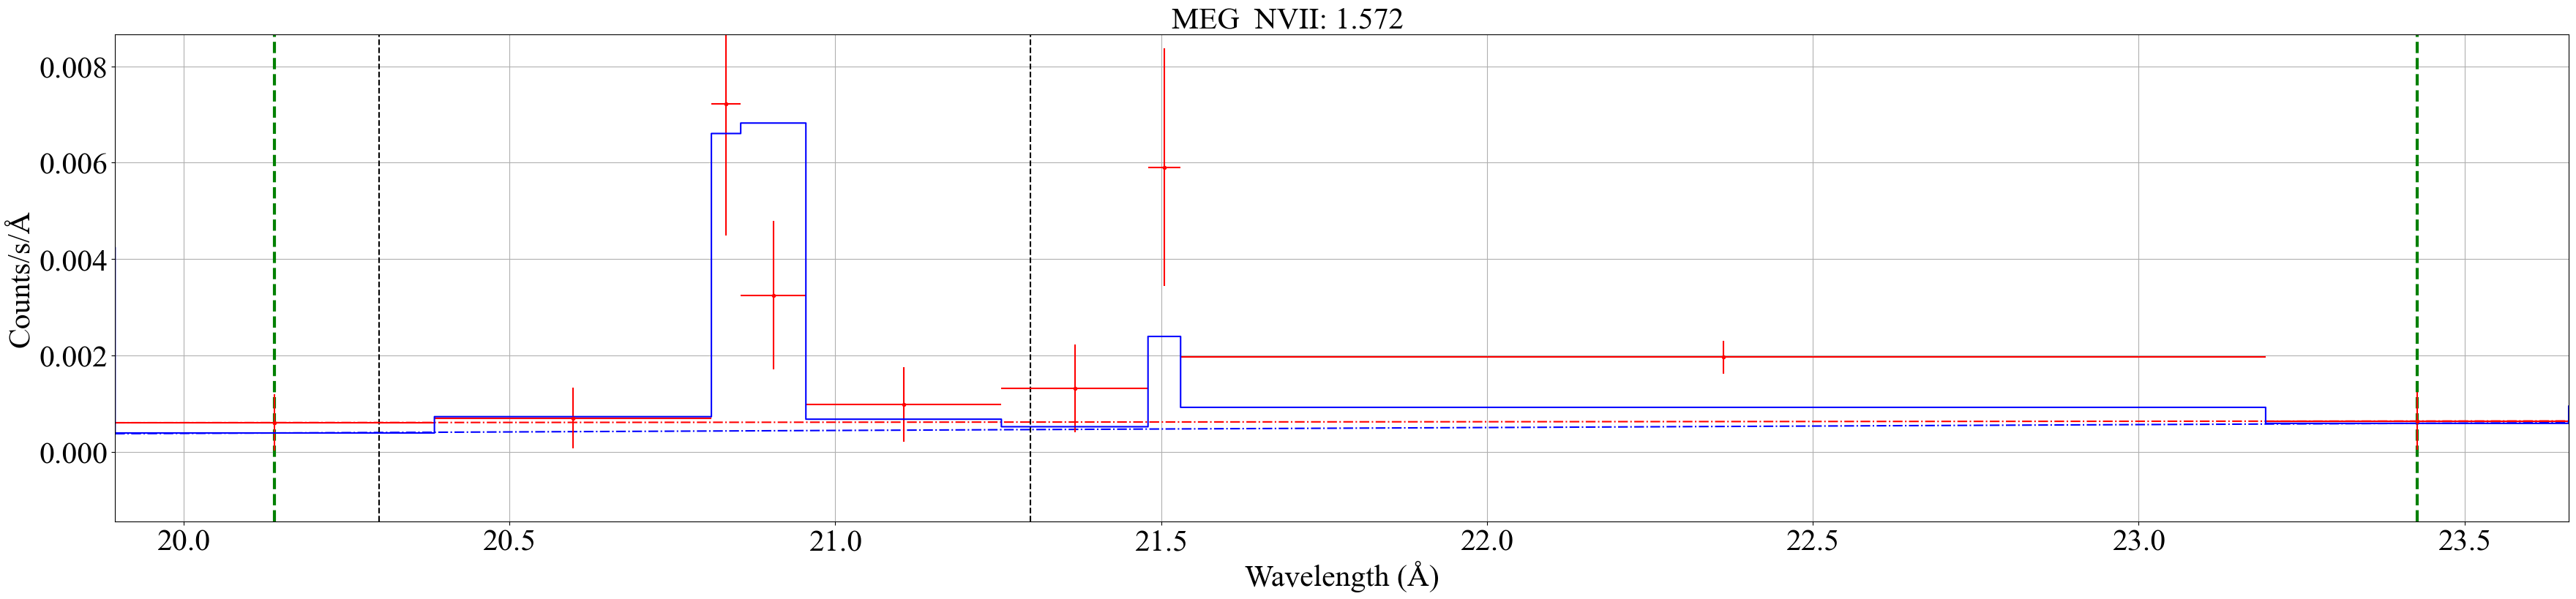

NVII not found in this dataset. HEG
Boundaries of the line: 20.3 21.3
NVII not found in this dataset. MEG
Boundaries of the line: 0.0 0.0
NVII not found in this dataset. HEG
Boundaries of the line: 0.0 0.0

continuum locations = 18.6300011 19.4475021


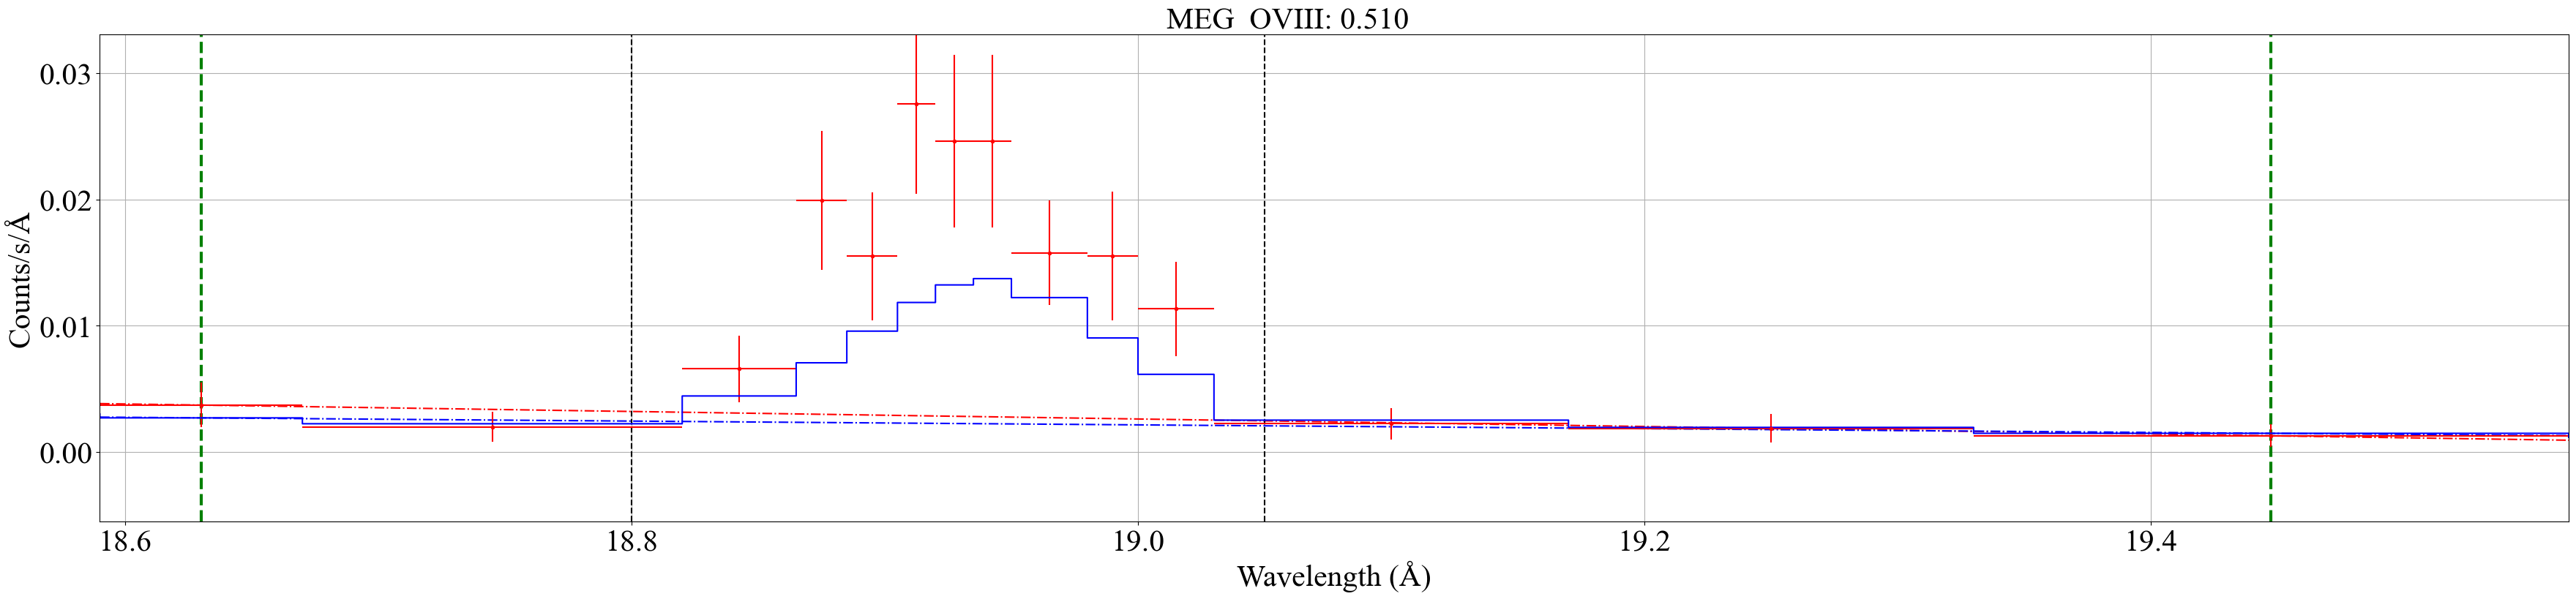

OVIII not found in this dataset. HEG
Boundaries of the line: 18.7 19.2

continuum locations = 16.4700012 17.2875023


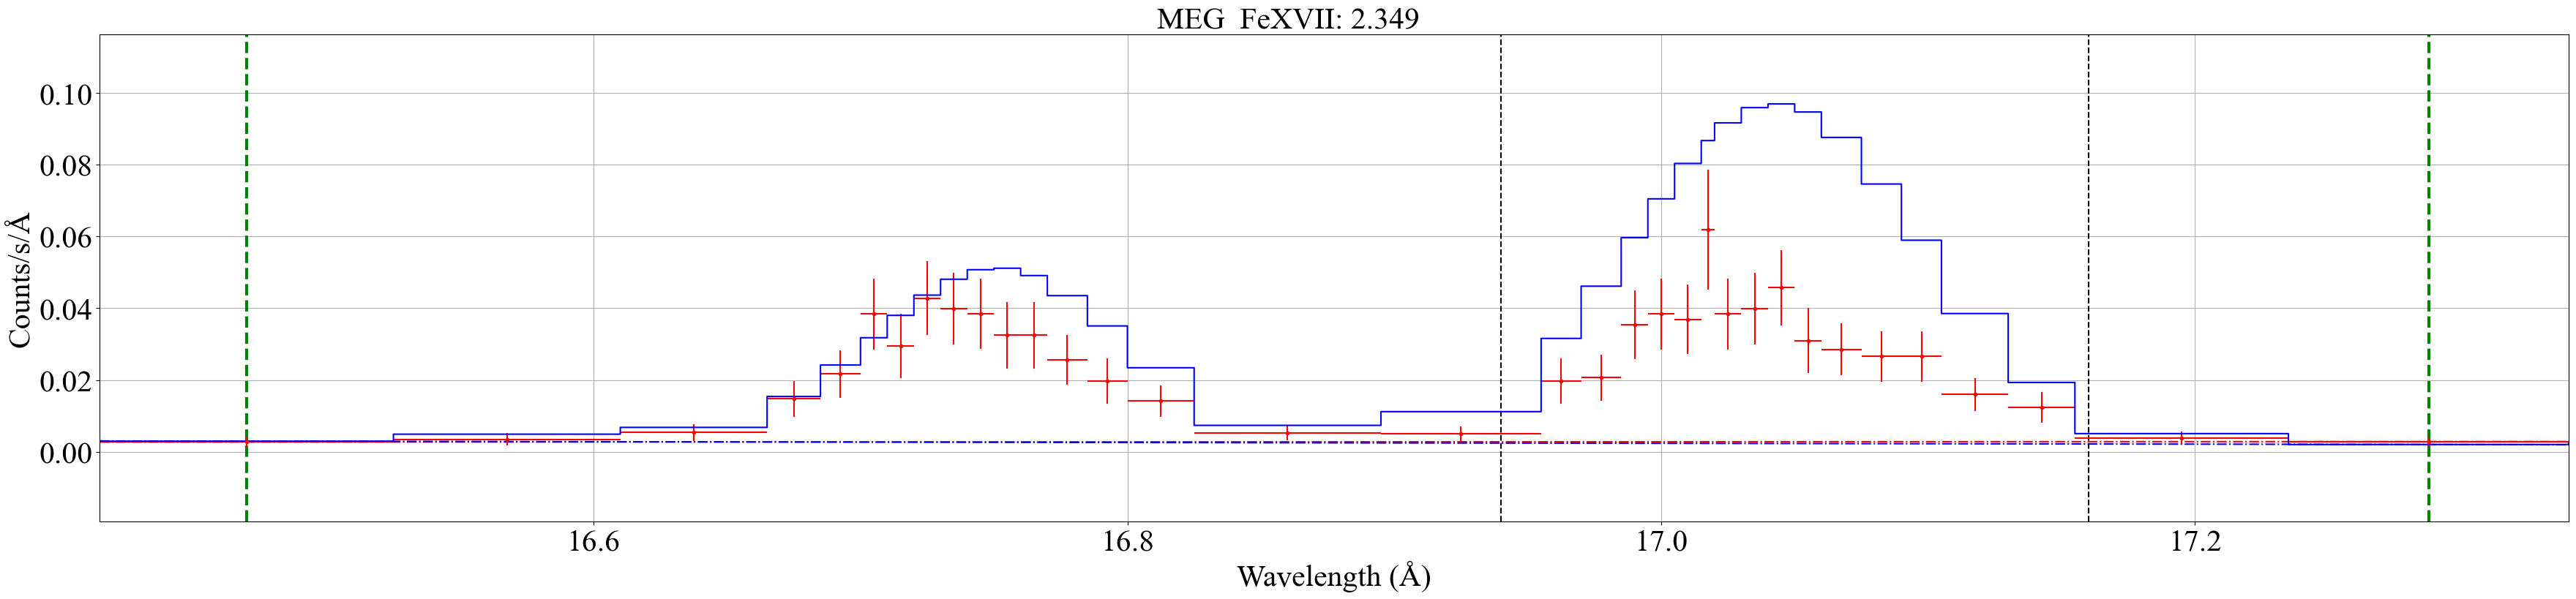


continuum locations = 16.4087524 19.5650024


C:\Users\shaka\AppData\Local\Temp\ipykernel_13364\1901901091.py:83: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(-ymax*.2, ymax*1.2)


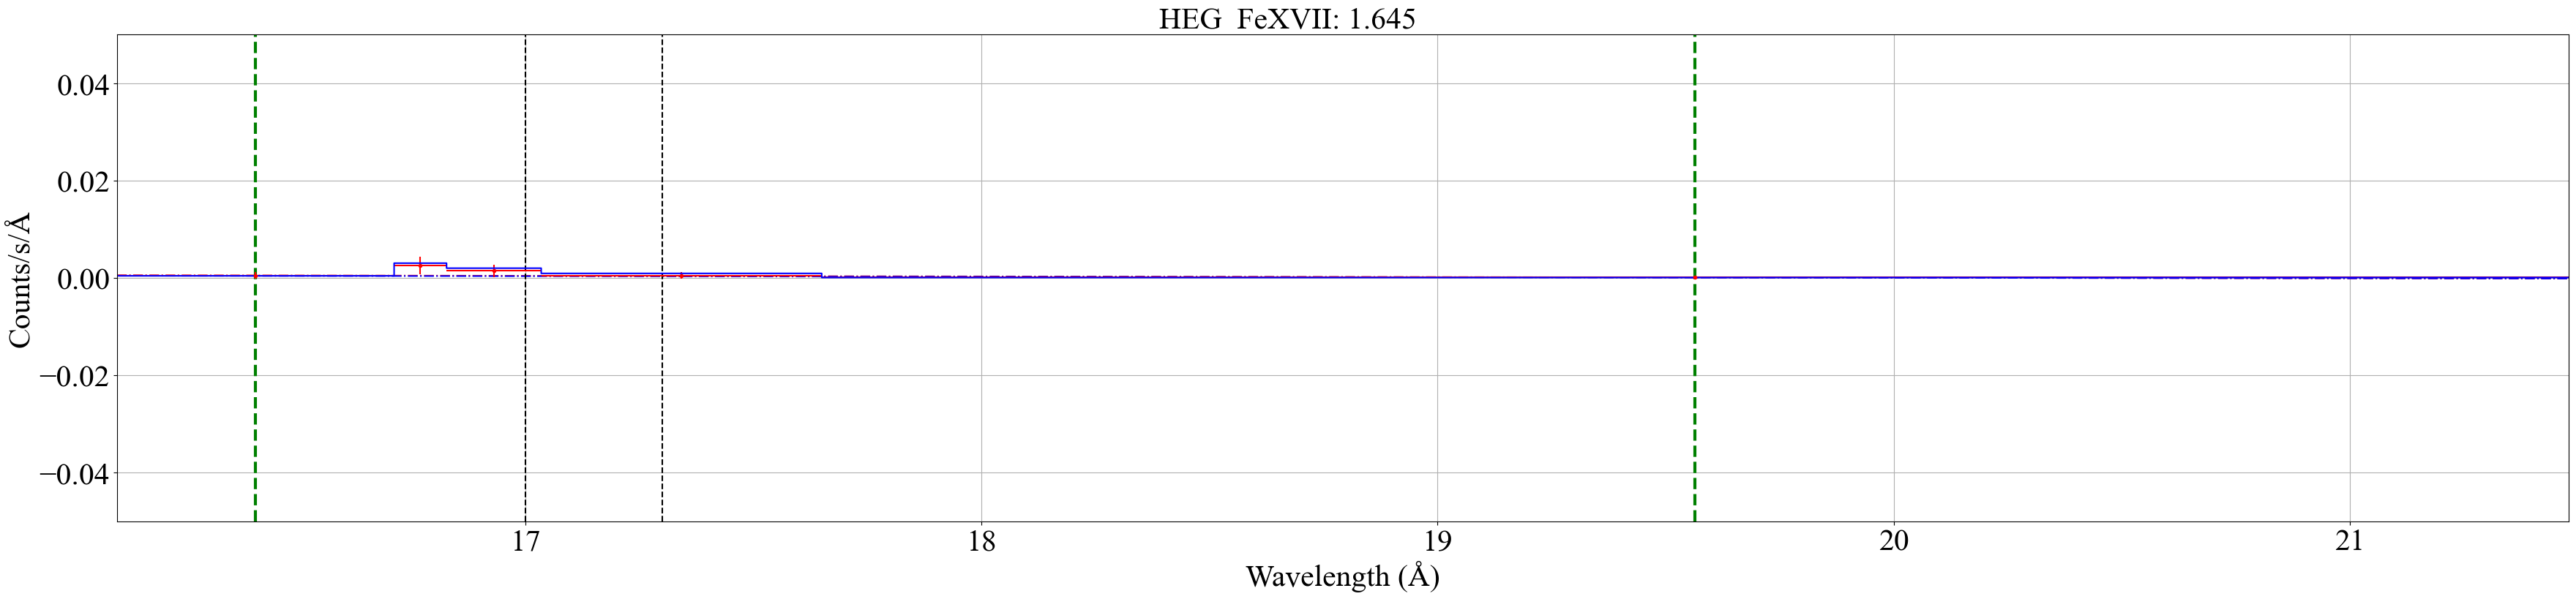


continuum locations = 16.4700012 17.2875023


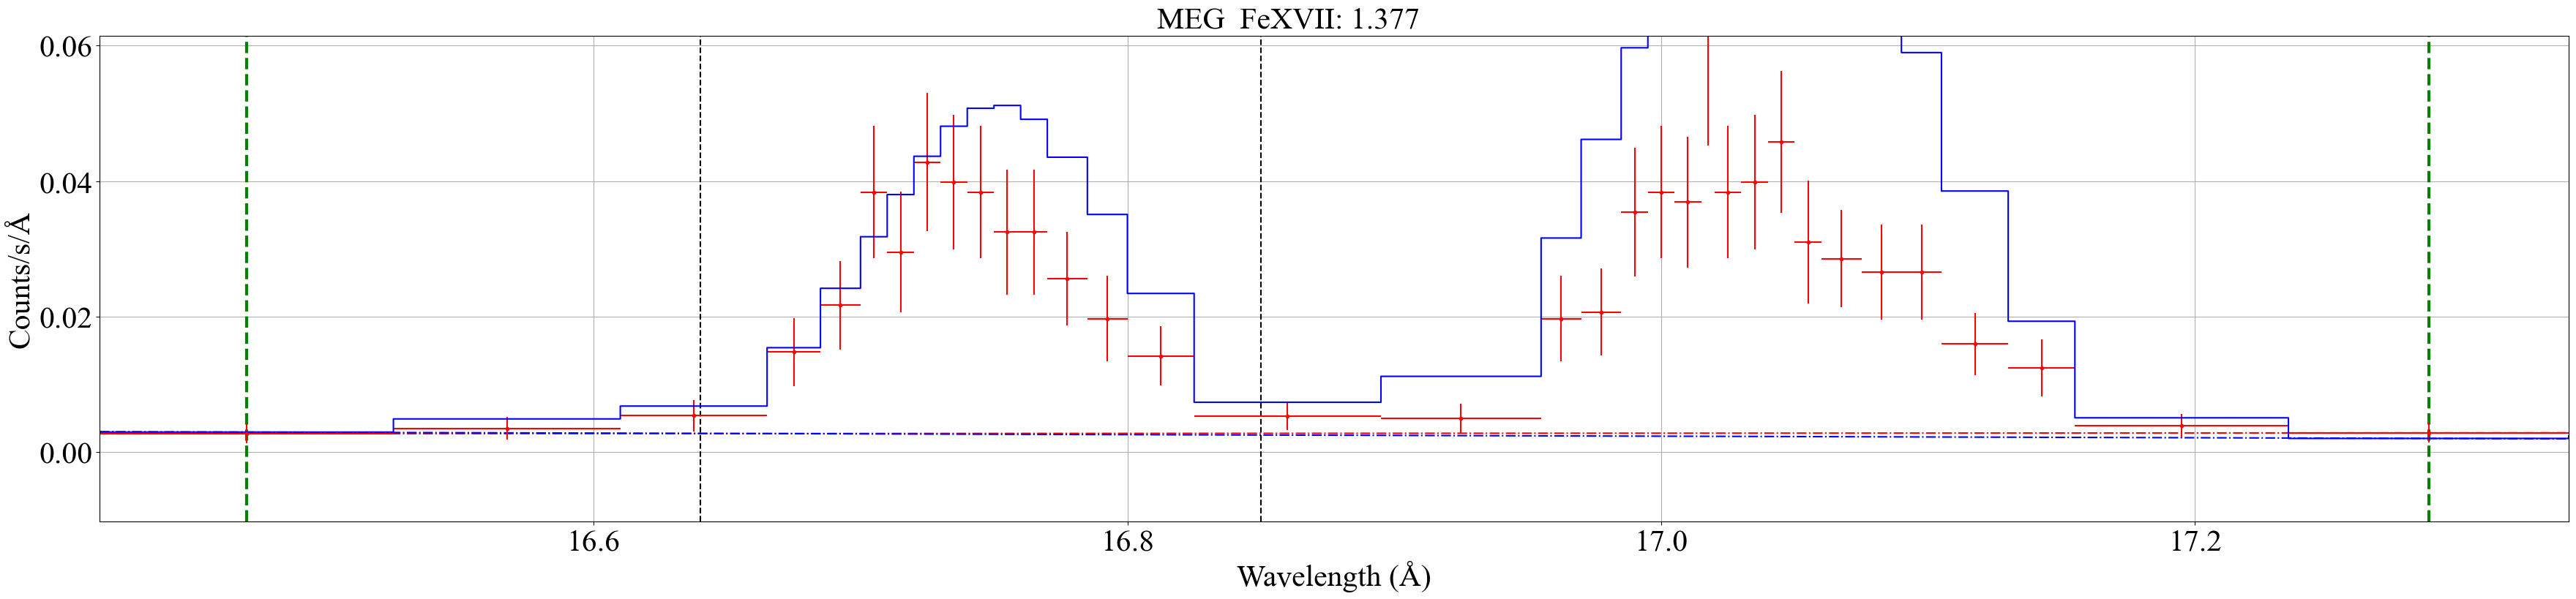


continuum locations = 16.4087524 19.5650024


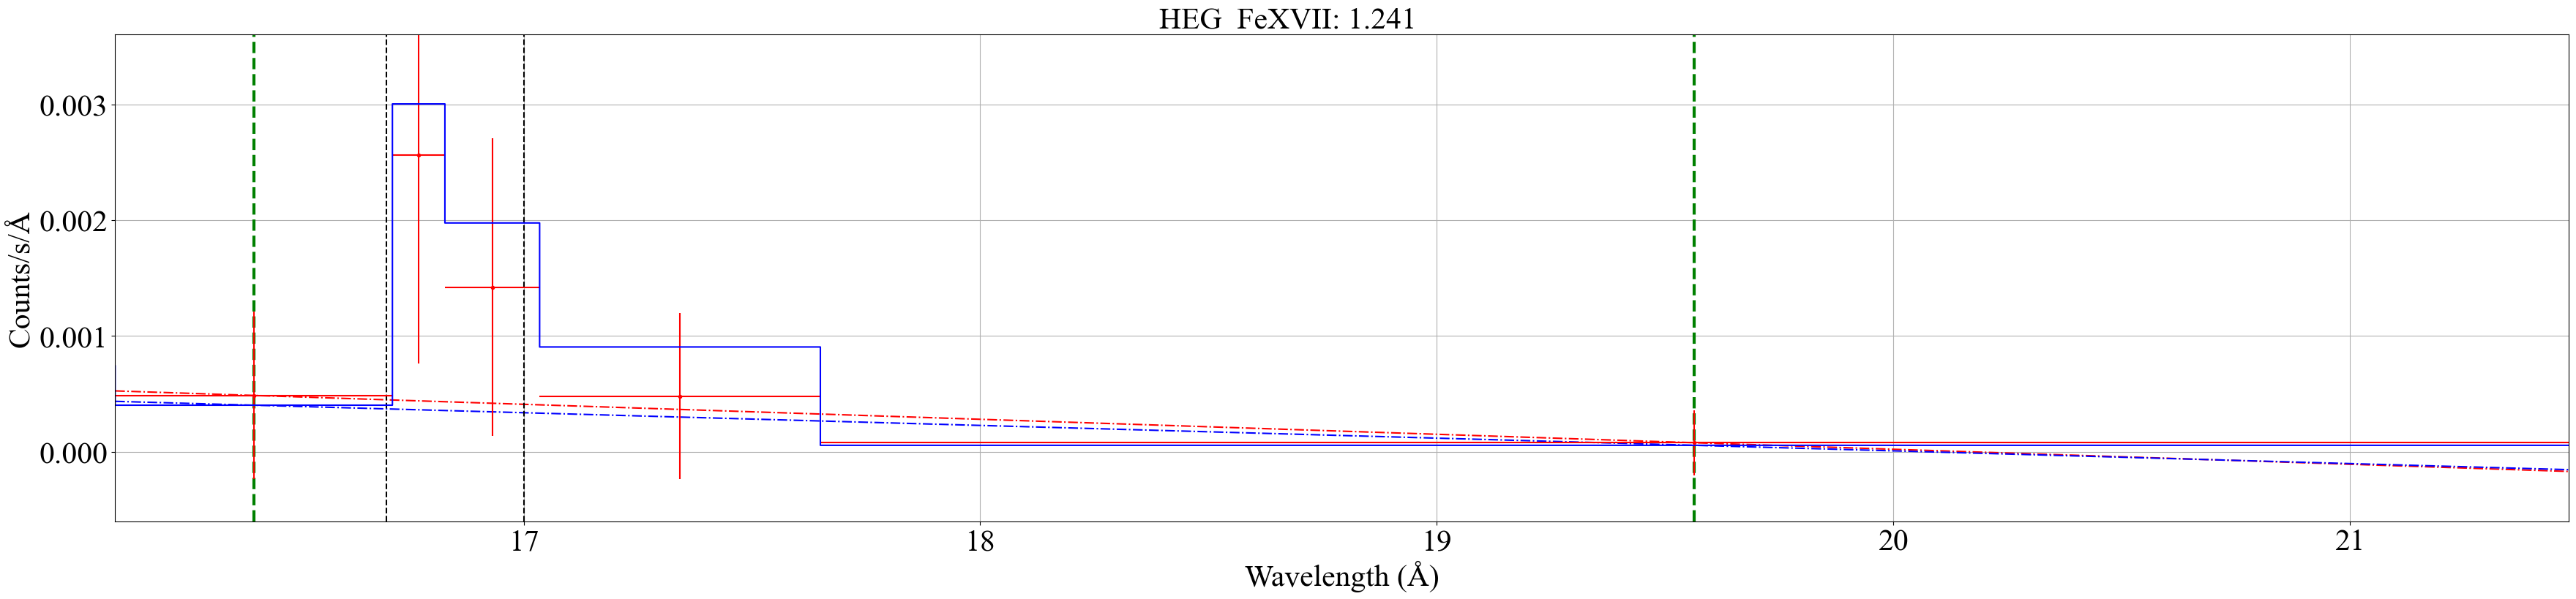


continuum locations = 15.7525015 16.3025017


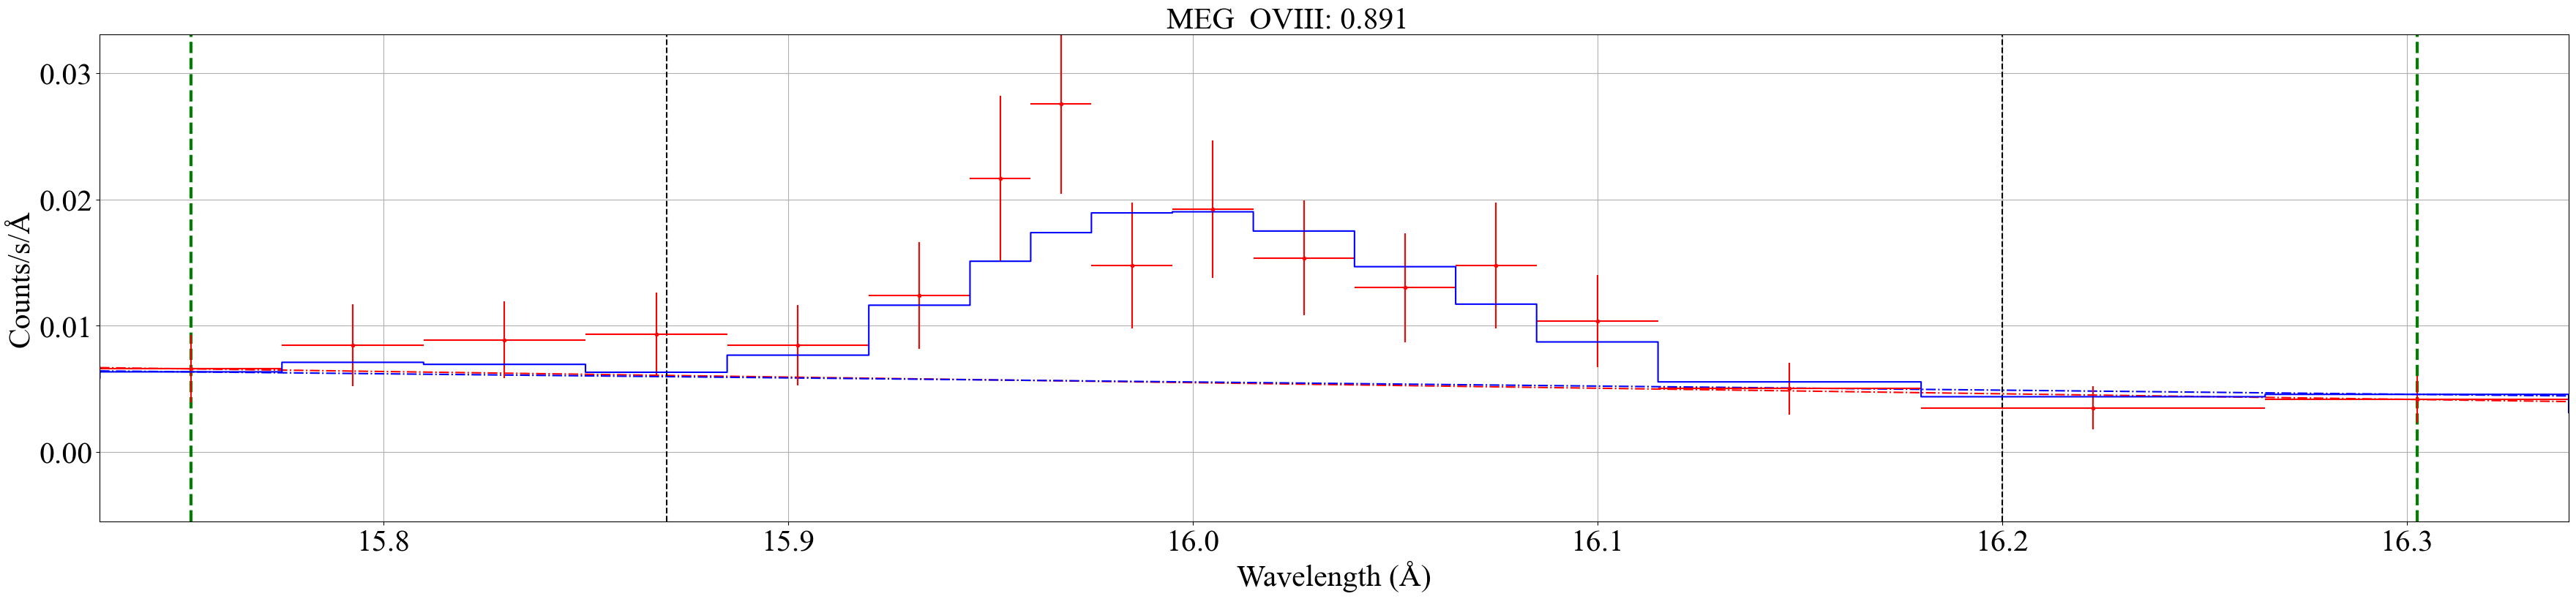

OVIII not found in this dataset. HEG
Boundaries of the line: 0.0 0.0

continuum locations = 14.8100014 15.5375013


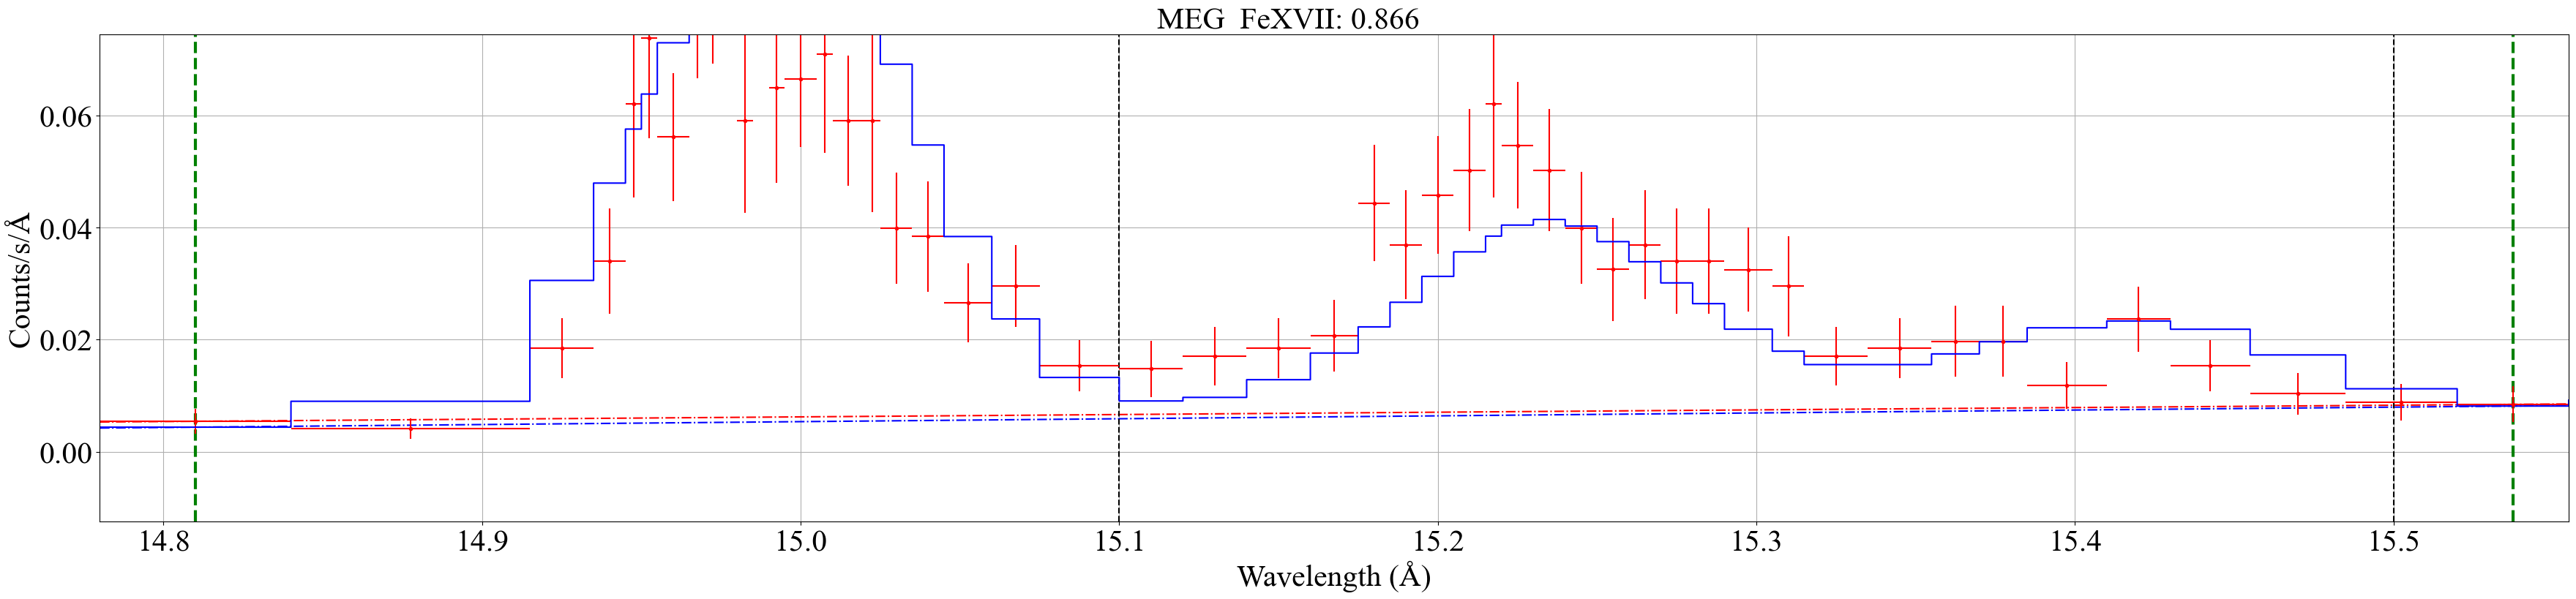


continuum locations = 14.7462511 15.5900011


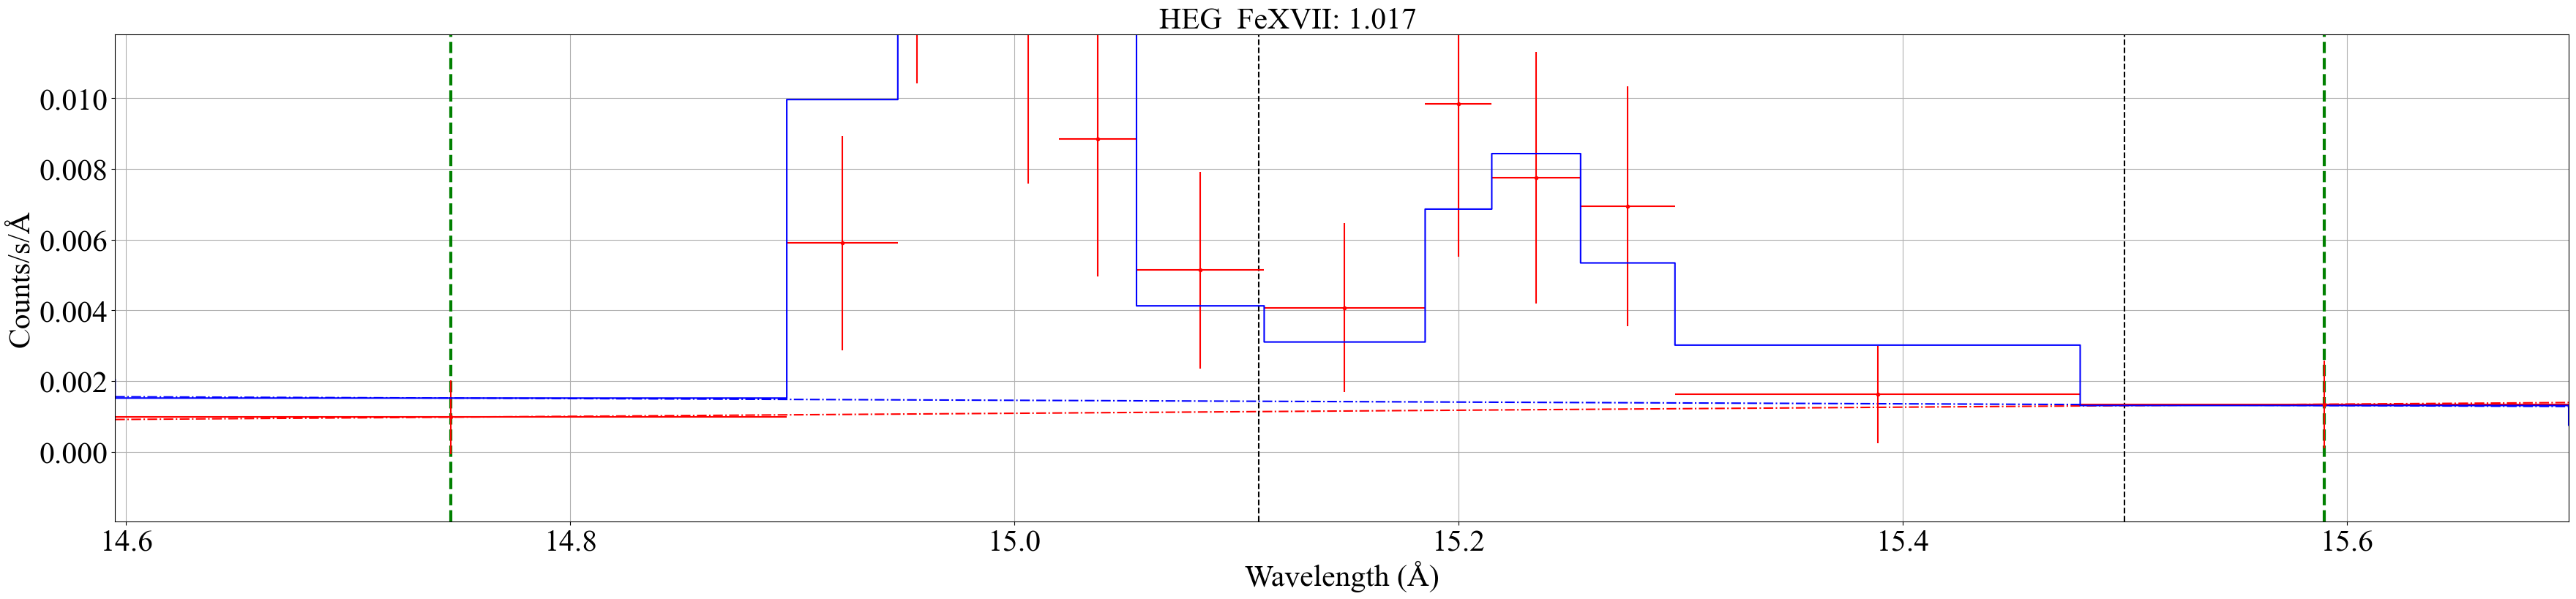


continuum locations = 14.8100014 15.5375013


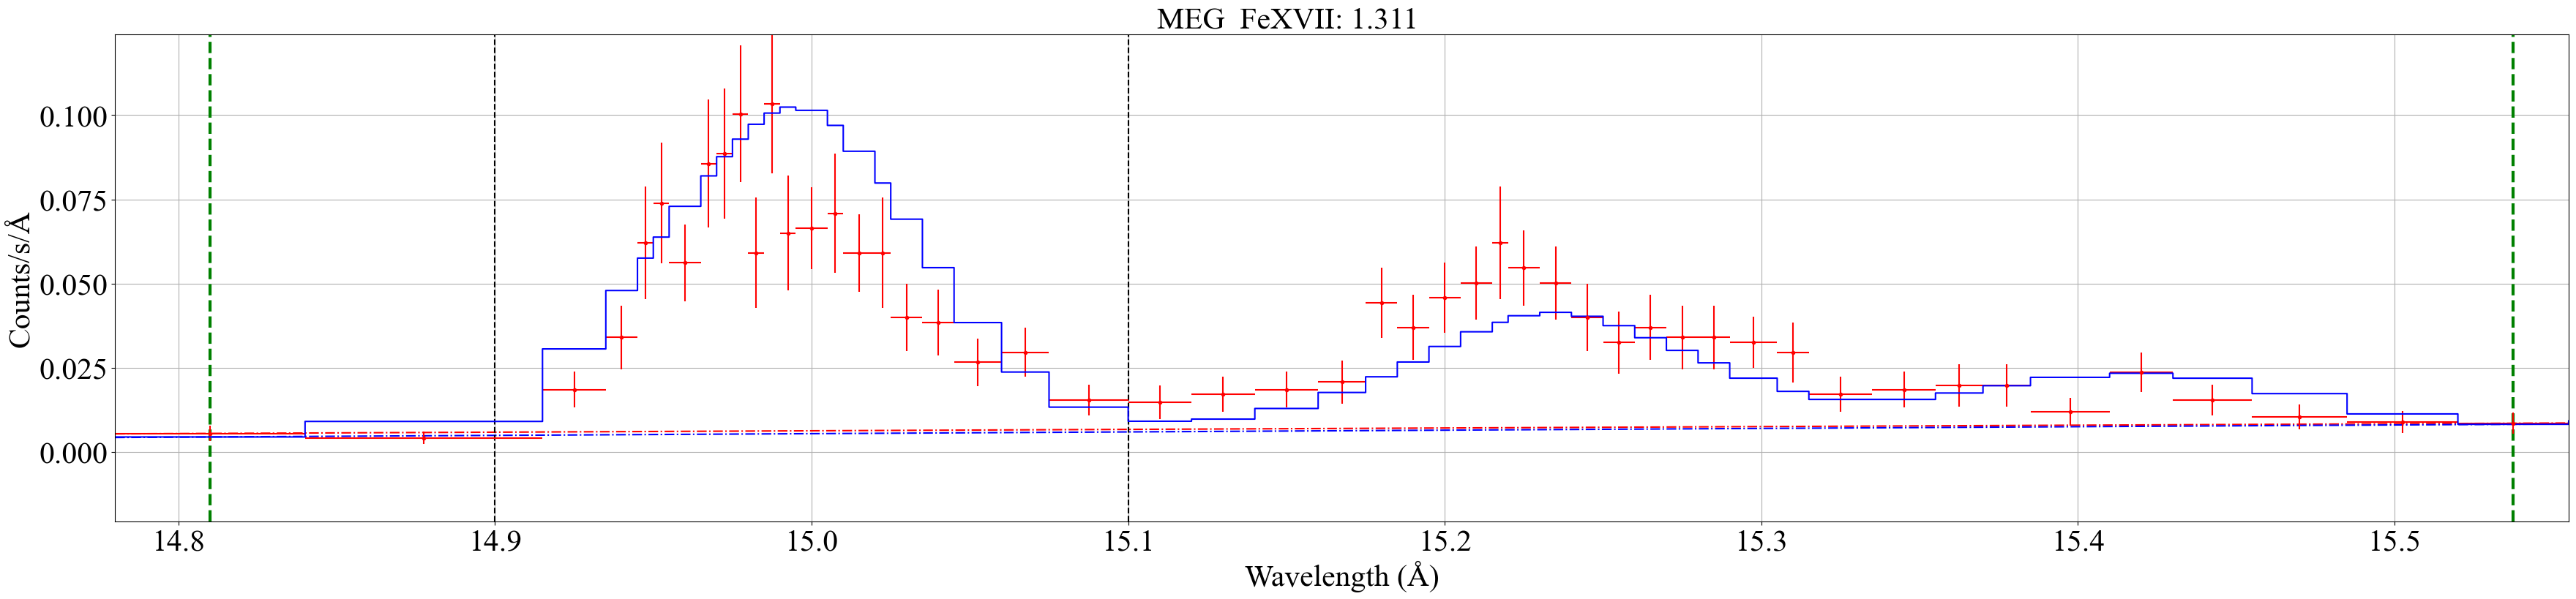


continuum locations = 14.7462511 15.5900011


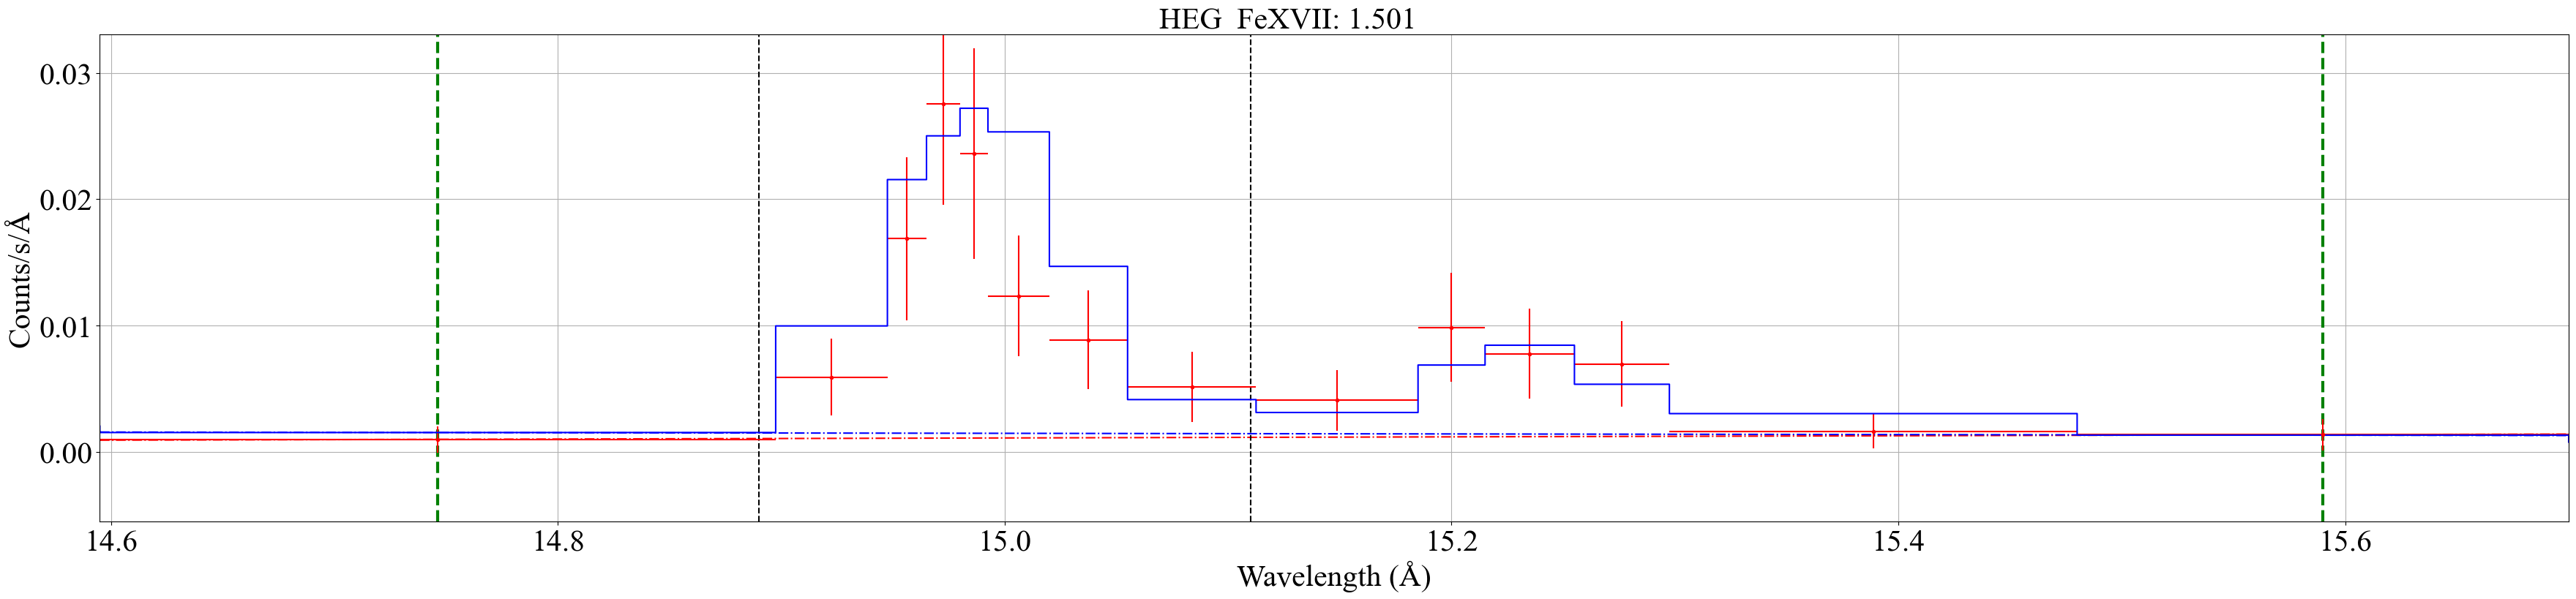


continuum locations = 13.9325018 14.4150009


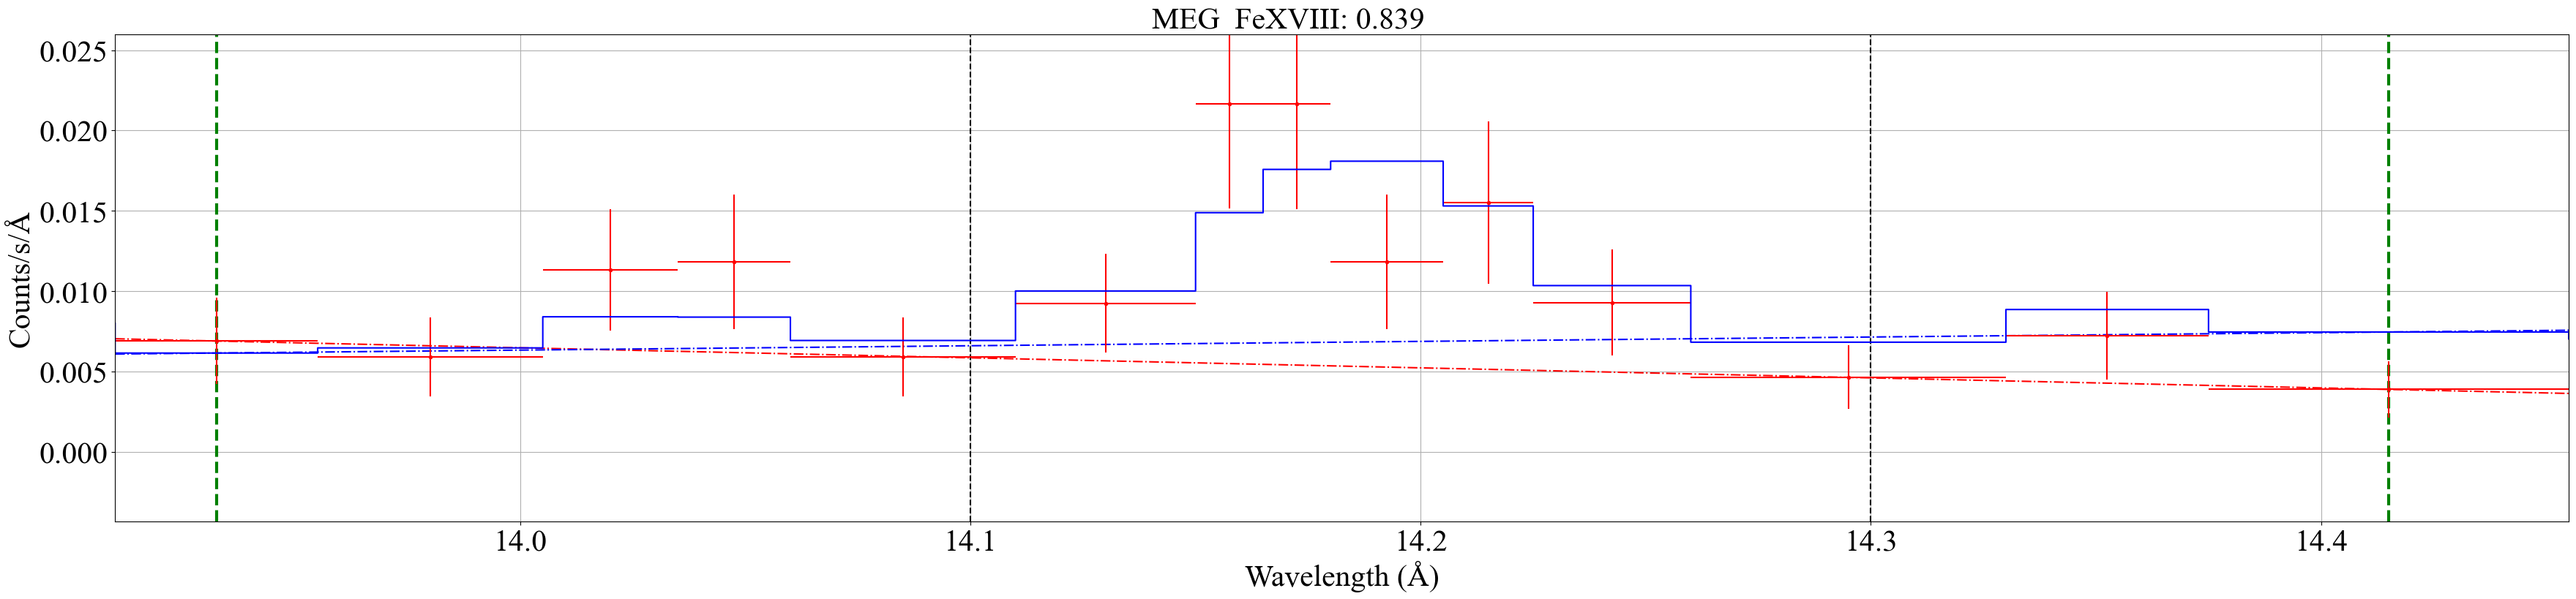


continuum locations = 14.000001 14.5400019


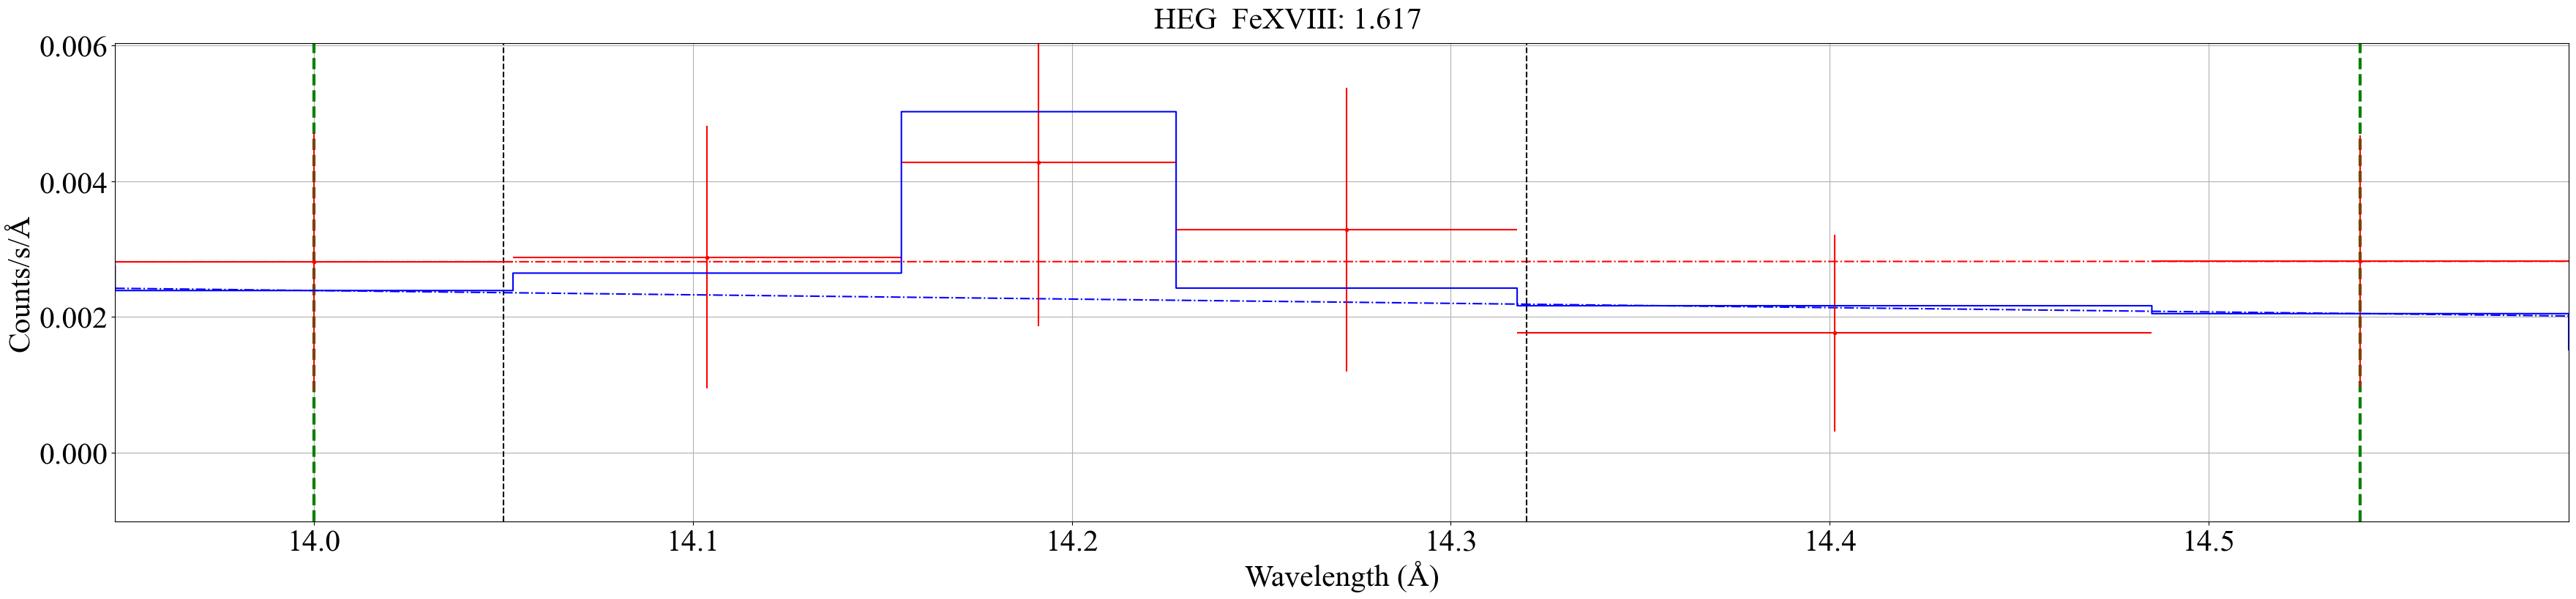


continuum locations = 13.3425007 13.8900013


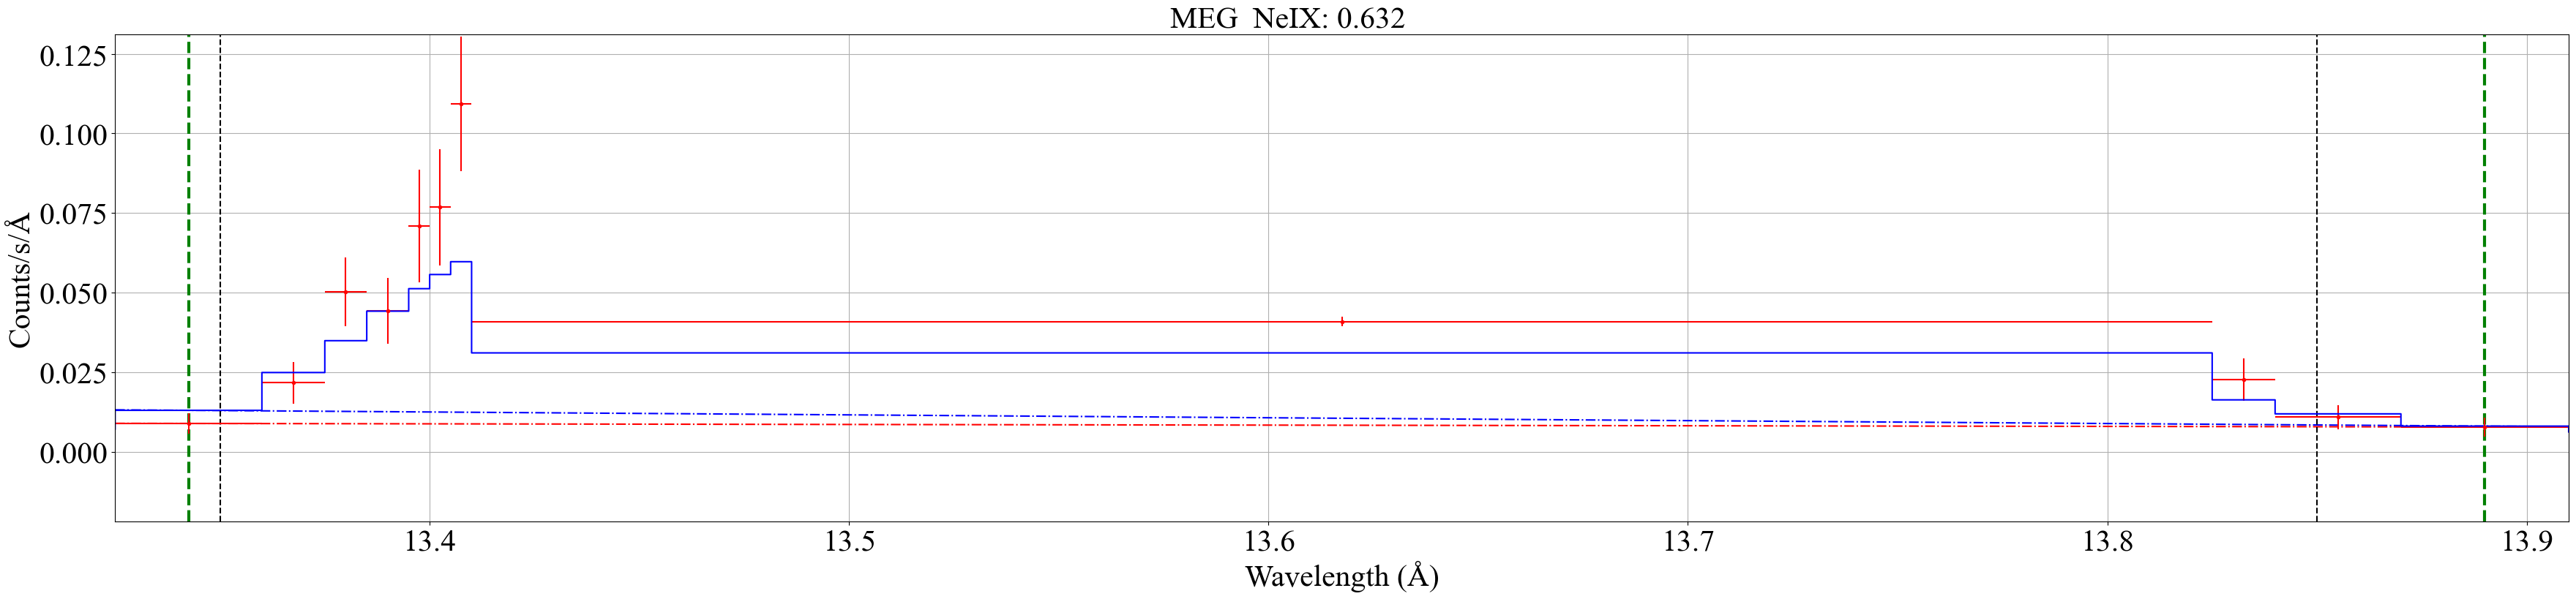


continuum locations = 13.2850008 13.8812513


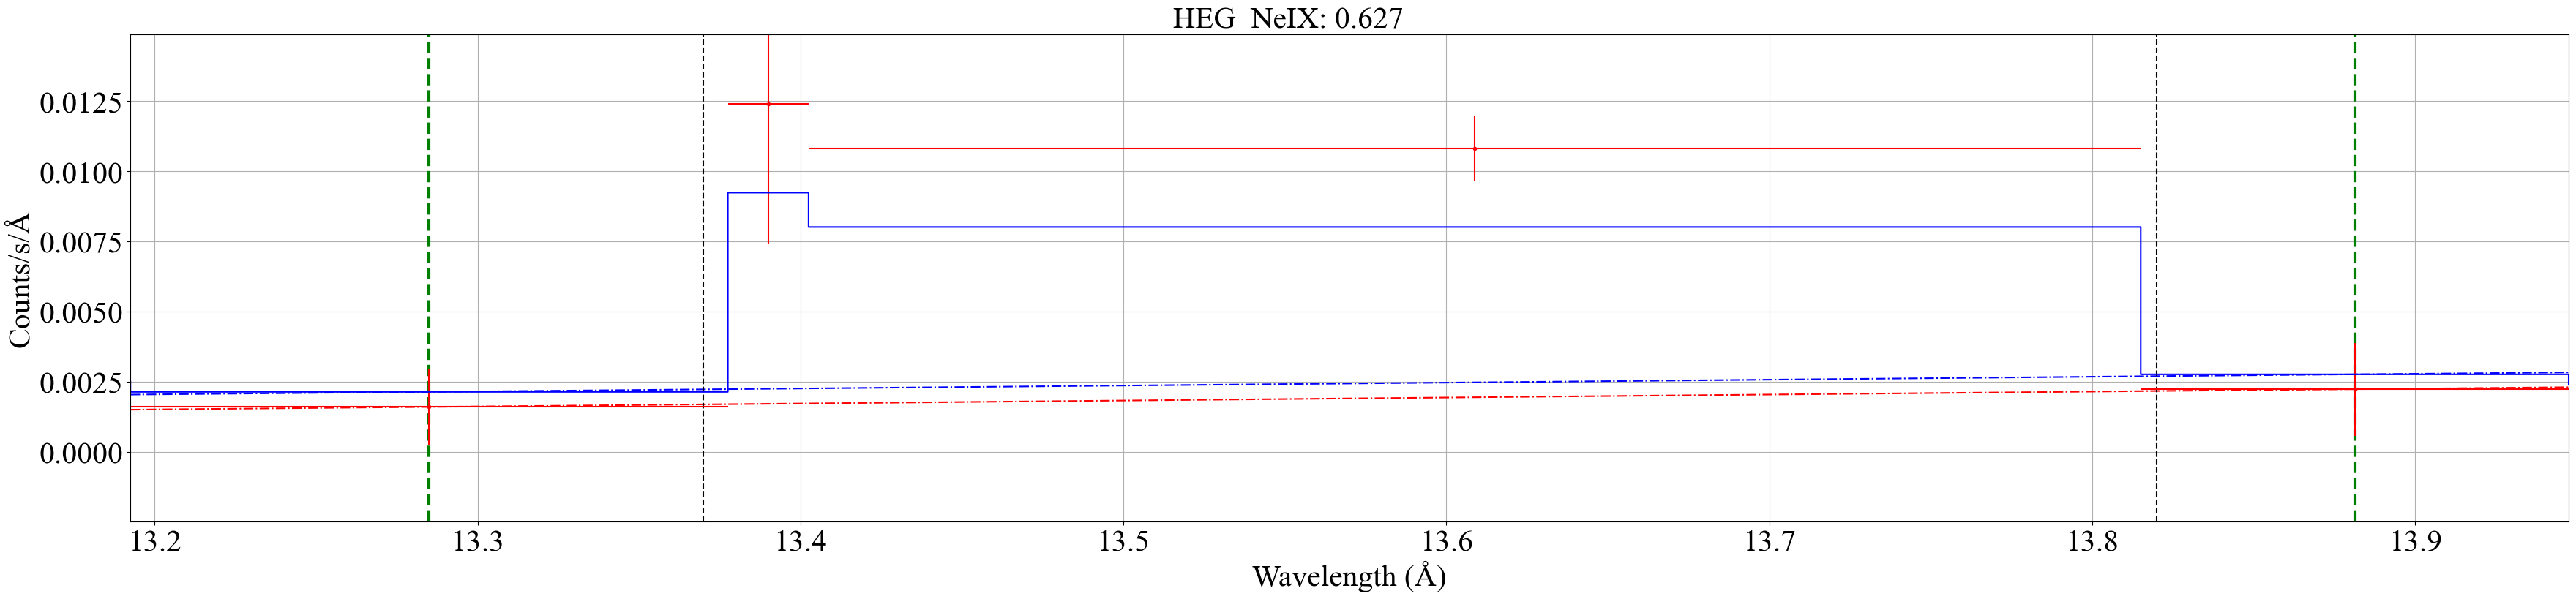


continuum locations = 12.0300007 12.3325005


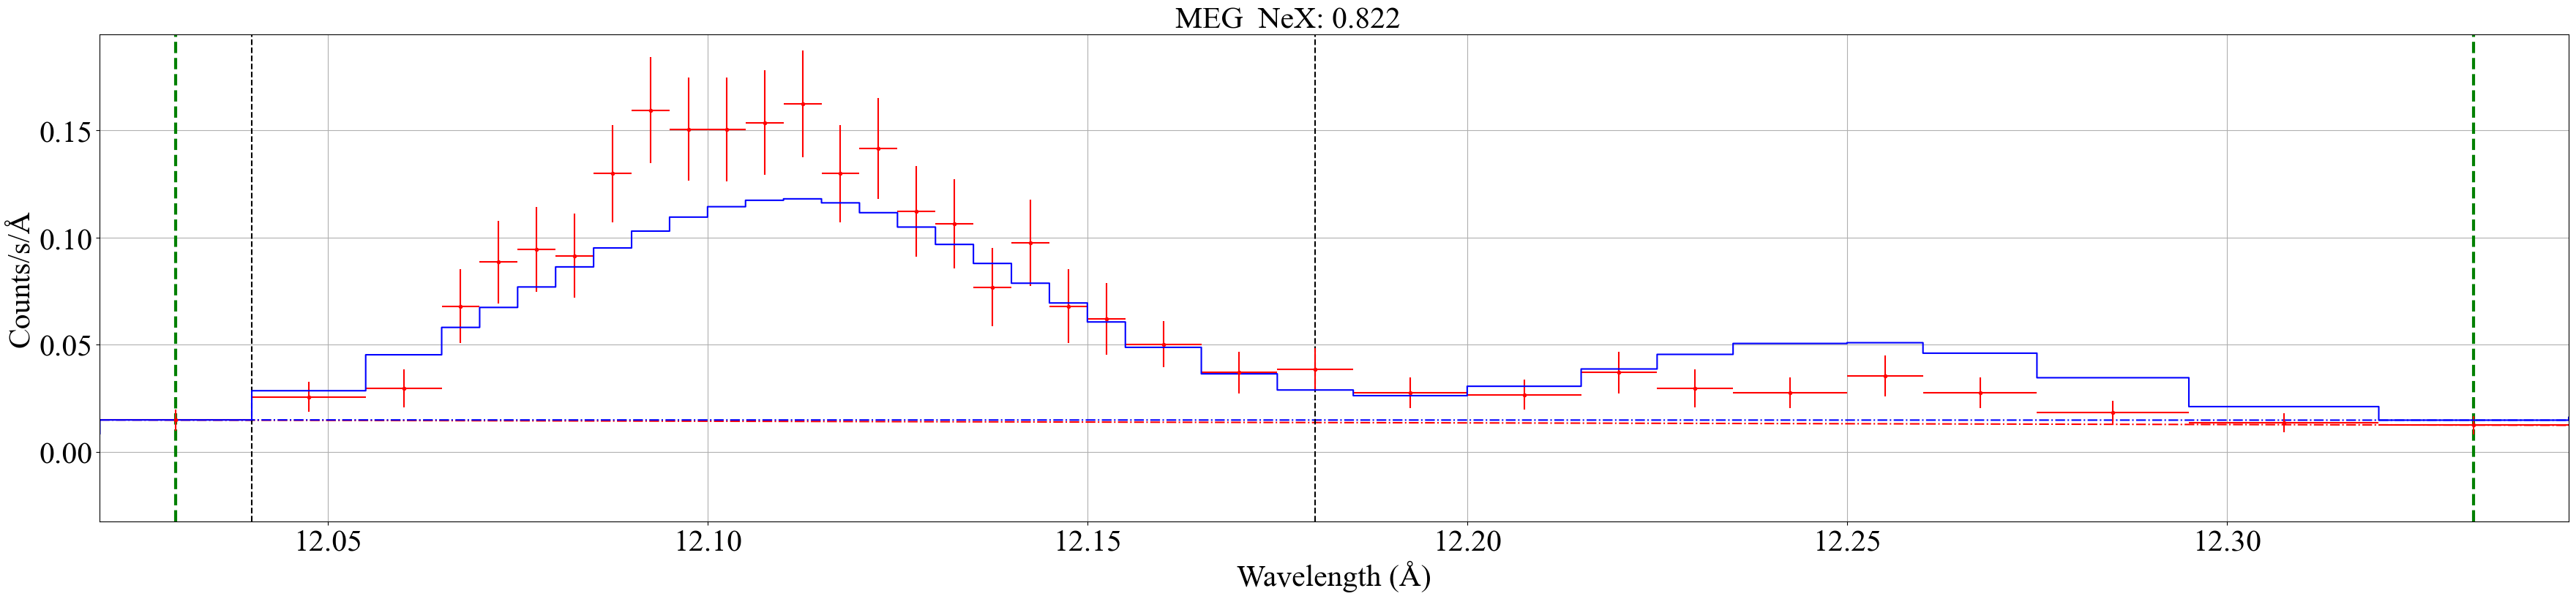


continuum locations = 11.888751 12.3400011


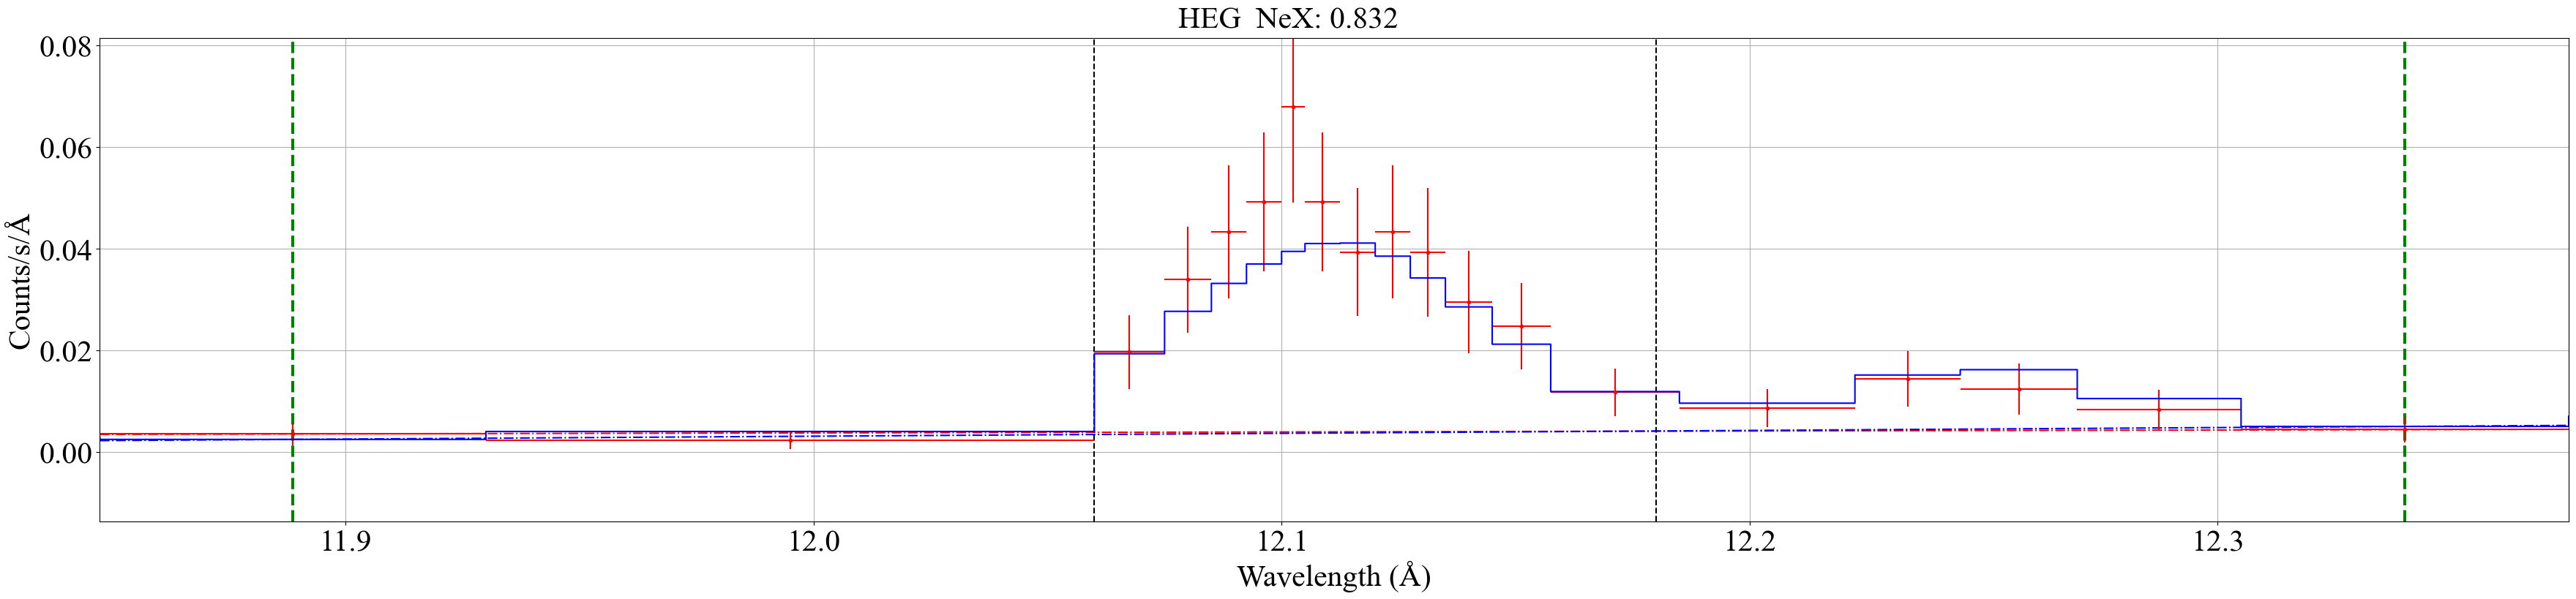


continuum locations = 8.96500015 9.41750145


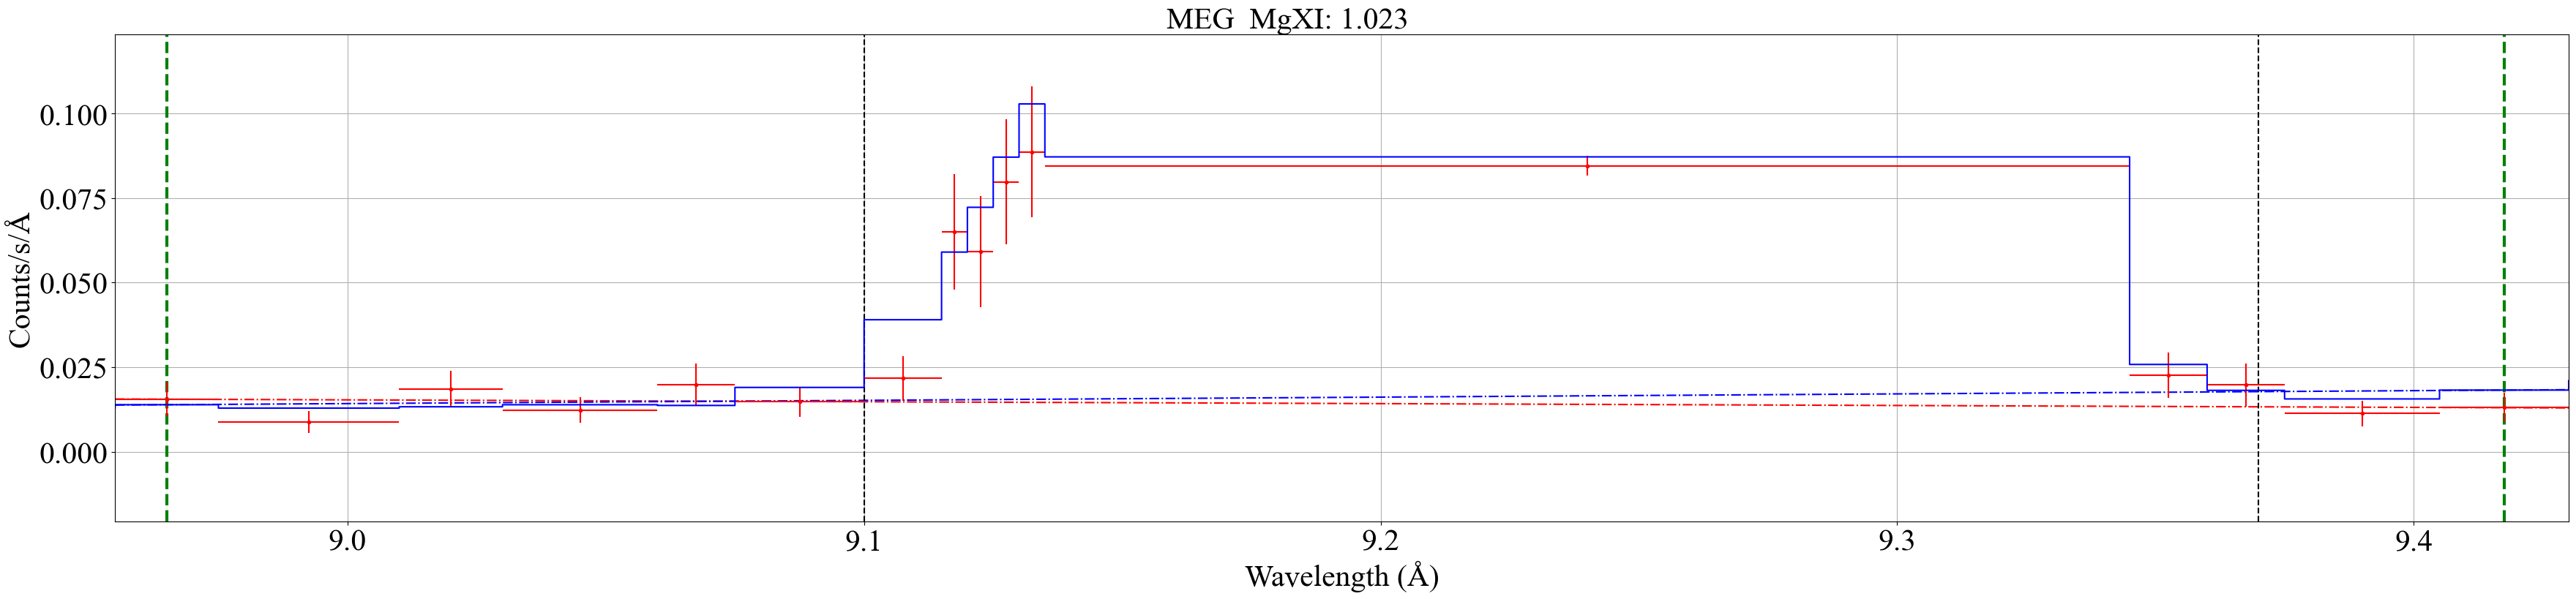


continuum locations = 8.95875072 9.45875072


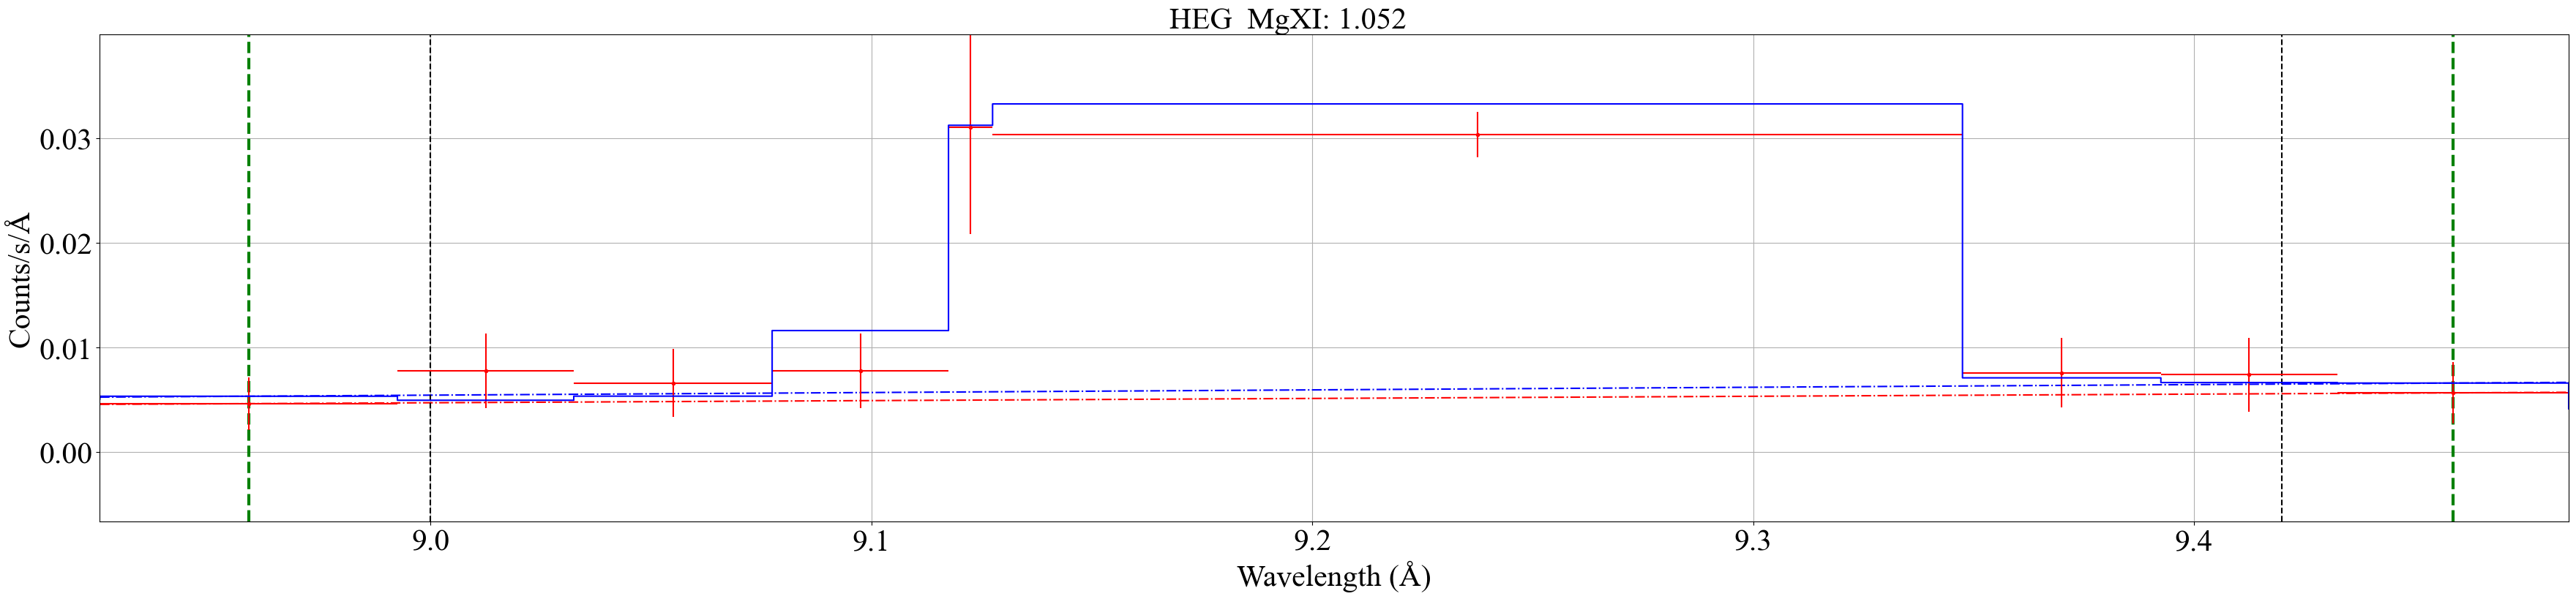


continuum locations = 8.2650013 8.52750111


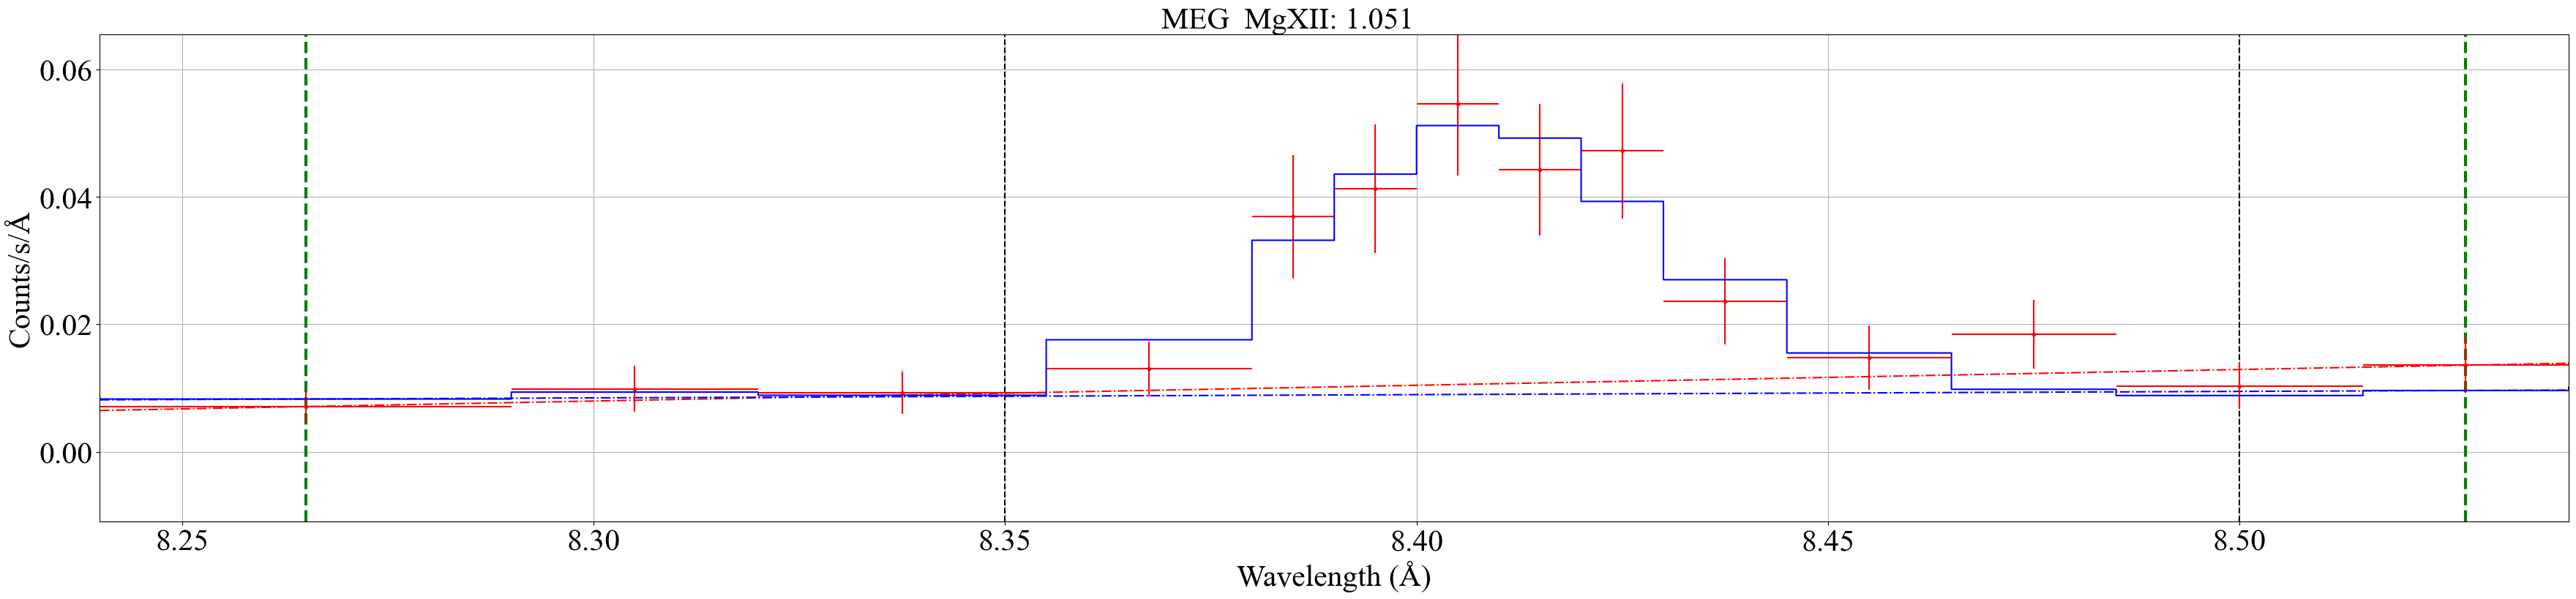


continuum locations = 8.26250076 8.55500031


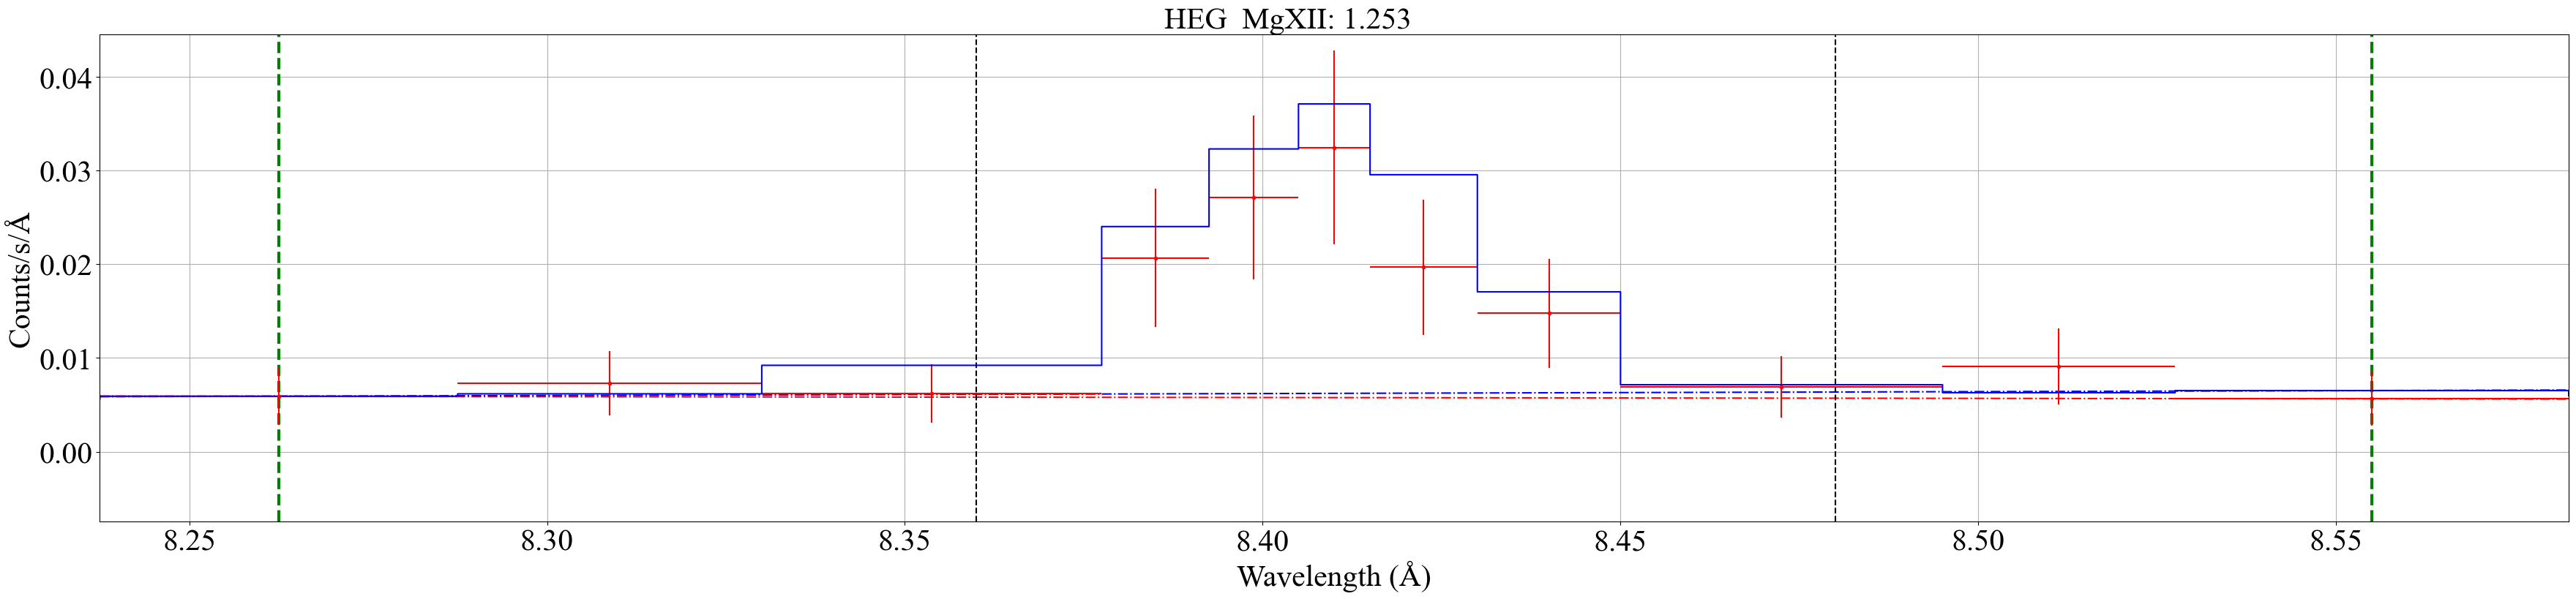


continuum locations = 6.46750069 6.81000042


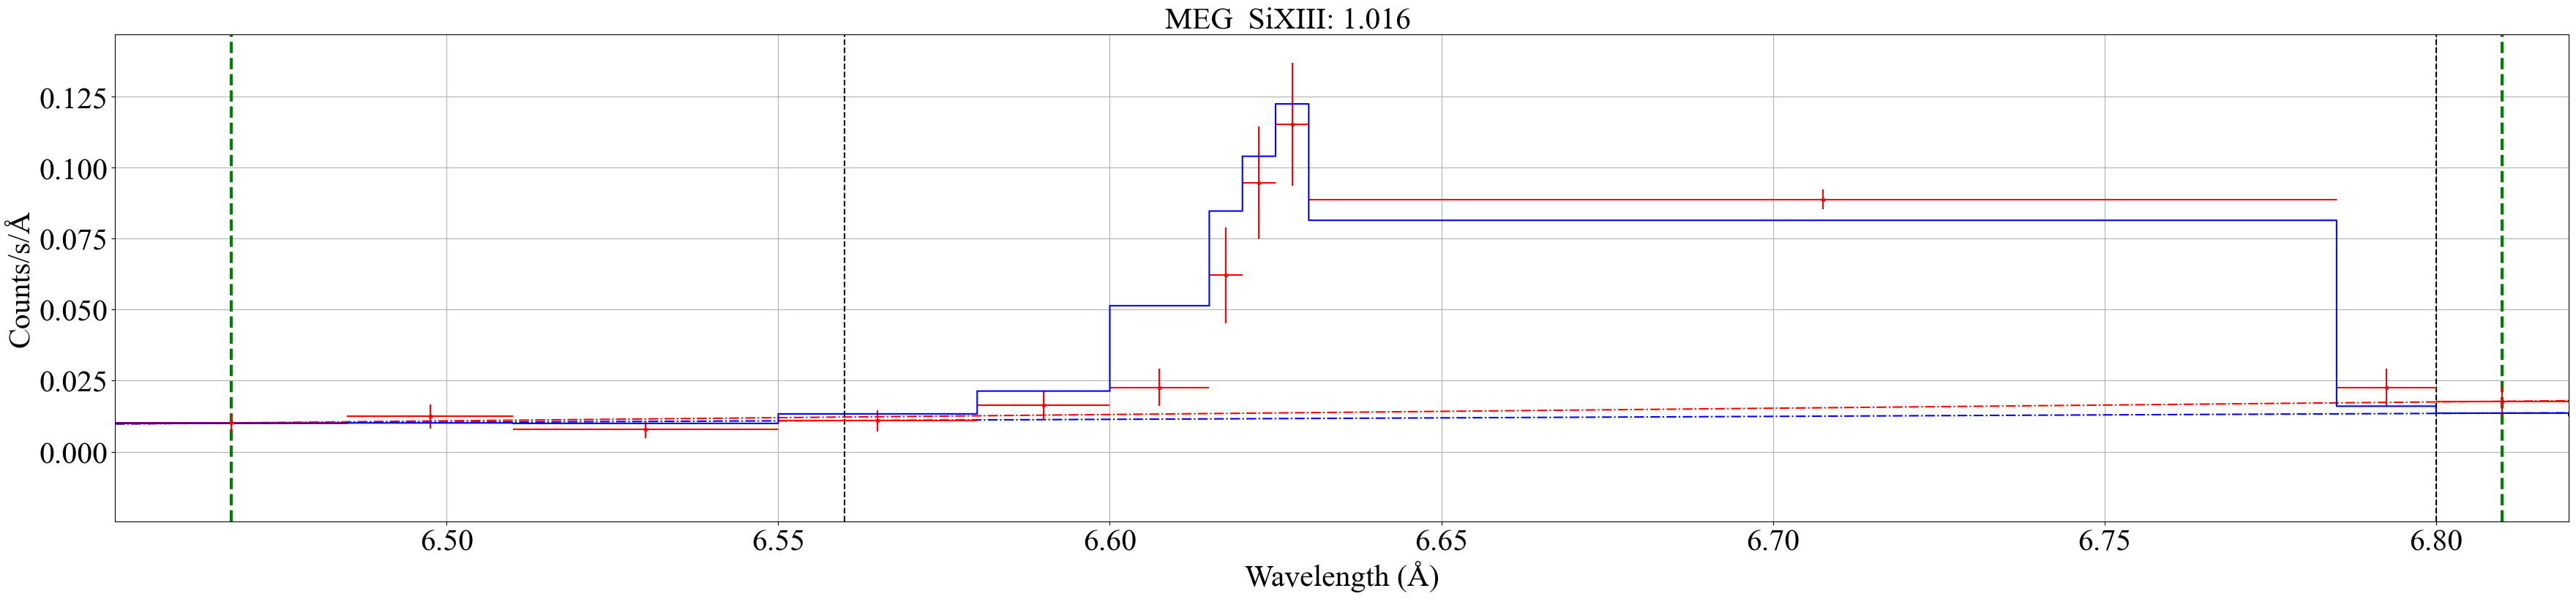


continuum locations = 6.42500067 7.07125092


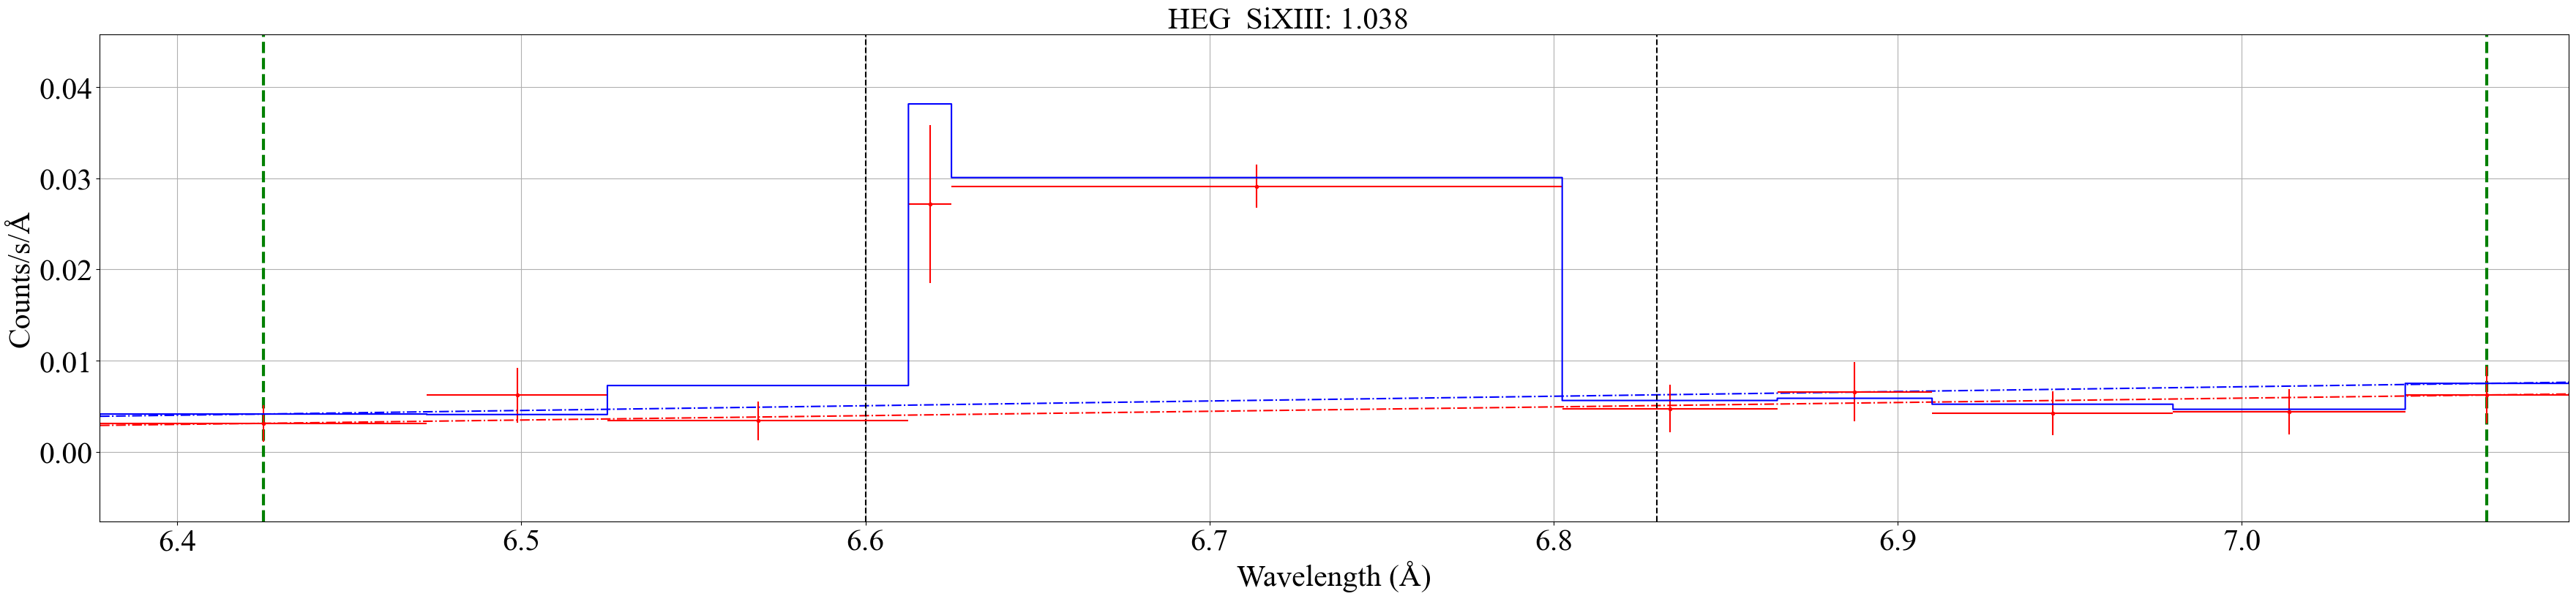

In [173]:
#plotting each individual line
for i in range(len(int_tot0)):
    plot_line(data, 0, histwvs,histvals, int_tot0[i],spec1)
    plot_line(data, 1, histwvs,histvals, int_tot1[i],spec2)

In [174]:
#little function needed for the line counts
def none_to_zero(x):
    if x == None:
        return 0.0
    else:
        return x

#polka dot plot creating function (works for HEG or MEG, not the combo)
def polkadot(inttot, dataset, filename):
    line_counts = [none_to_zero(inttot[i][3]) for i in range(len(inttot))] #continuum-subtracted data integral
    max_line = max(line_counts)
    x = []
    y = []
    sizes = []
    label = []
    color = []
    plt.rcParams['figure.figsize'] = (7,4)
    fig, ax = plt.subplots()
    for i in range(len(inttot)):
        if inttot[i][3]!=None: #as long as the line is present in the data
            if inttot[i][11]>0 and inttot[i][11]<2.25: #if data-to-model flux ratio is positive and not one of the few outliers
                x.append(line_locs[i]) #add x-coordinates to list
                y.append(inttot[i][11]) #add y-coordinates to list
                sizes.append(300*inttot[i][3]/max_line) #dot area is proportional to number of counts in line
                label.append(inttot[i][0]) #add line label
                color.append(line_temps[i]/1e6) #add color for line temperature
            if inttot[i][11]>2.25: print('WARNING: %s flux ratio >2.25' %(line_names[i])) #alerting if a dot is off the graph
            if inttot[i][11]<0.45: print('WARNING: %s flux ratio <0.45' %(line_names[i]))
        
    cplot=ax.scatter(x, y,s=sizes,c=color,cmap=mp.colormaps['cool_r'])
    for i, txt in enumerate(label):
        ax.annotate(txt, (x[i],y[i]*1.03))

    
    plt.axhline(y=1, color='k', linestyle='--',linewidth=0.5) #line for perfect ratio of 1
    plt.axhline(y=0.8, color='gray', linestyle='--',linewidth=0.5) #lines for +/-25% difference from ratio of 1
    plt.axhline(y=1.25, color='gray', linestyle='--',linewidth=0.5)
    plt.xlabel("Wavelength (Å)",fontsize=15,fontname=tnr)
    plt.ylabel("Model-to-Data Flux Ratio",fontsize=15,fontname=tnr)
    
    ax.set_yscale('log')
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_minor_locator(plt.NullLocator())
    ax.set_yticks([.5,.8,1.0,1.25,2.0])
    ax.set_yticklabels(['0.5','0.8','1.0','1.25','2.0'],fontname=tnr,fontsize=15)
    plt.xlim(5,max(histwvs[0])*1.1)
    plt.ylim(.4,2.5)
    plt.xticks(fontname=tnr,fontsize=15)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.text(6,2,"%s %s %s\n%s, %s" %(starname, obsID, dataset, binsize, heii),fontsize=12,fontname=tnr)
    plt.tight_layout(pad=1)
    im=ax.scatter(x,y,s=sizes,c=color,cmap=mp.colormaps['cool_r'],vmin=1,vmax=10)

    cbar=fig.colorbar(im,ax=ax,ticks=[2,4,6,8,10],cmap="cool_r")
    cbar.ax.set_yticklabels(["2", '4', '6','8','10'],fontname=tnr)

    if filename: plt.savefig(filename)
    
    plt.show()
    

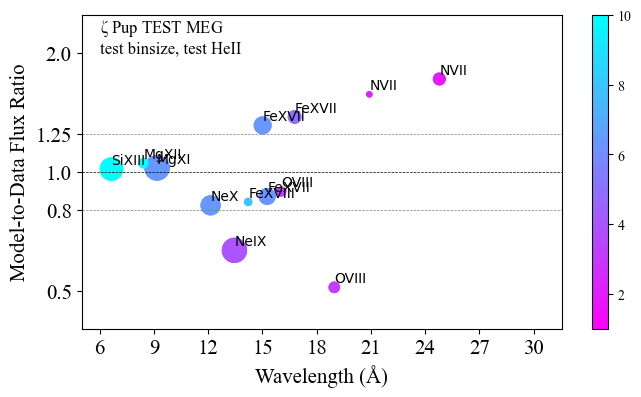

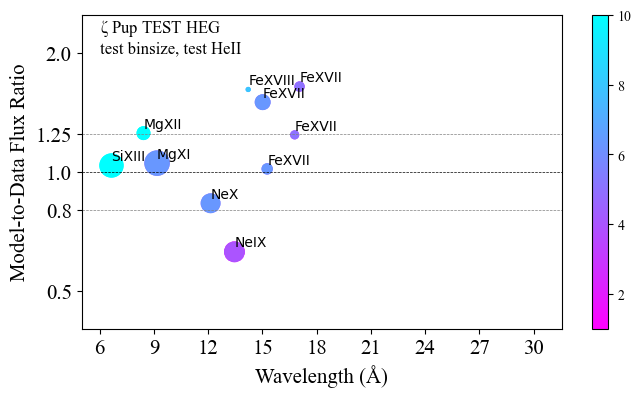

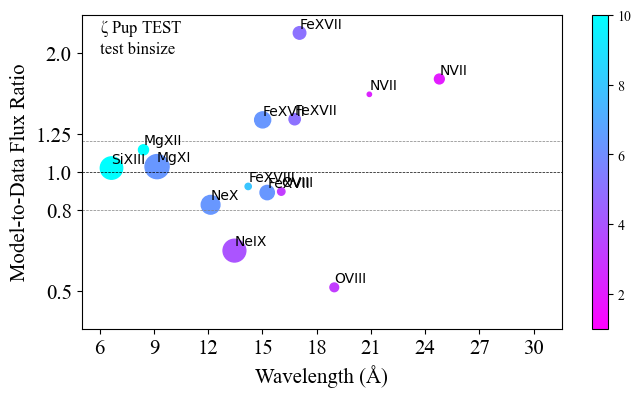

In [175]:

#plotting MEG/RGS1 polka dot plot
polkadot(int_tot0, spec1, spec1dot_name)

#plotting HEG/RGS2 polka dot plot
polkadot(int_tot1, spec2, spec2dot_name)

#combined spectra 1 and spectra 2 polka dot plot
#MEG/RGS1 data
line_counts0 = [none_to_zero(int_tot0[i][3]) for i in range(len(int_tot0))] #continuum-subtracted data integral
# HEG/RGS2 data
line_counts1 = [none_to_zero(int_tot1[i][3]) for i in range(len(int_tot1))]
# calculate and plot the combined ratios
weighted_ratios = [] #we do (MEG model + HEG model)/(MEG data + HEG data) instead of (MEG ratio + HEG ratio)/2
for i in range(len(int_tot0)):
    if int_tot0[i][3] == None and int_tot1[i][3] == None:
        weighted_ratios.append(None)
    elif int_tot0[i][3] == None:
        weighted_ratios.append(int_tot1[i][4]/int_tot1[i][3])
    elif int_tot1[i][3] == None:
        weighted_ratios.append(int_tot0[i][4]/int_tot0[i][3])
    else:
        total_data = int_tot0[i][3]+int_tot1[i][3]
        total_model = int_tot0[i][4]+int_tot1[i][4]
        weighted_ratios.append(total_model/total_data)
combined_flux = []
for i in range(len(int_tot0)):
    if int_tot0[i][3] == None and int_tot1[i][3] == None:
        combined_flux.append(0)
    elif int_tot0[i][3] == None:
        combined_flux.append(int_tot1[i][3])
    elif int_tot1[i][3] == None:
        combined_flux.append(int_tot0[i][3])
    else:
        combined_flux.append(int_tot0[i][3]+int_tot1[i][3])
max_line2 = max(combined_flux)
plt.rcParams['figure.figsize'] = (7,4)
fig, ax = plt.subplots()
x = []
y = []
sizes = []
label2 = []
color = []
for i in range(len(int_tot1)):
    if int_tot1[i][3] != None or int_tot0[i][3] != None:
        if weighted_ratios[i]>0 and weighted_ratios[i]<2.25:
            x.append(line_locs[i])
            y.append(weighted_ratios[i])
            sizes.append(300*combined_flux[i]/max_line2)
            label2.append(int_tot0[i][0])
            color.append(line_temps[i]/1e6)
        if weighted_ratios[i]>2.25: print('WARNING: %s flux ratio >2.25' %(line_names[i])) #alerting if a dot is off the graph
        if weighted_ratios[i]<0.45: print('WARNING: %s flux ratio <0.45' %(line_names[i]))

for i, txt in enumerate(label2):
    ax.annotate(txt, (x[i],y[i]*1.03))
im=ax.scatter(x,y,s=sizes,c=color,cmap=mp.colormaps['cool_r'],vmin=1,vmax=10)
plt.axhline(y=1, color='k', linestyle='--',linewidth=0.5)
plt.axhline(y=0.8, color='gray', linestyle='--',linewidth=0.5)
plt.axhline(y=1.2, color='gray', linestyle='--',linewidth=0.5)
plt.xlabel("Wavelength (Å)",fontsize=15,fontname=tnr)
plt.ylabel("Model-to-Data Flux Ratio",fontsize=15,fontname=tnr)
ax.set_yscale('log')
plt.xticks(fontname=tnr,fontsize=15)
ax.yaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_minor_locator(plt.NullLocator())
ax.set_yticks([.5,.8,1,1.25,2.0])
ax.set_yticklabels(['0.5','0.8','1.0','1.25','2.0'],fontname=tnr,fontsize=15)
plt.ylim(.4,2.5)
plt.xlim(5,max(histwvs[0])*1.1)
plt.xticks(fontname=tnr,fontsize=15)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.text(6,2,"%s %s\n%s" %(starname, obsID, binsize),fontsize=12,fontname=tnr)
plt.tight_layout(pad=1)

cbar=fig.colorbar(im,ax=ax,ticks=[2,4,6,8,10],cmap="cool_r")
cbar.ax.set_yticklabels(["2", '4', '6','8','10'],fontname=tnr)

plt.savefig(dot_name)
plt.show()

In [176]:
#defining the plotting spectra function
def plotspectra(dataset, wvs, vals, bins, errs, Histwvs, Histmods, savefile_name):
    plt.rcParams['figure.figsize'] = (11.25, 6.0)
    fig, ax = plt.subplots()
    
    ax.errorbar(wvs, vals, xerr=bins, yerr=errs, fmt='.', alpha=1, color='tab:blue', linewidth=1.5)
    ax.plot(Histwvs, Histmods, color='tab:brown', linewidth=2)

    #x boundaries
    lowbound = 4.5  #default
    highbound = max(wvs)+.5
    #OR
    #lowbound = 25  #custom
    #highbound = 32

    plt.xlim(lowbound,highbound)
    
    #uses the emission line .txt file to add markers/labels to the lines.
    for i in range(len(line_locs)):
        if line_locs[i]>highbound: continue  #skips lines outside the wavelength bounds
        if line_locs[i]<lowbound: continue   
        if abs(line_locs[i]-line_locs[i-1])<0.3 and line_names[i]==line_names[i-1]:  #takes the label away from lines that are too close together
            plt.vlines(line_locs[i],0,max(vals)*1.3,linestyle='dashed',color='pink')
            continue     
        plt.vlines(line_locs[i],0,max(vals)*1.3,linestyle='dashed',color='pink')
        plt.text(line_locs[i]+0.07,max(vals)*1.1, line_names[i],fontname=tnr,rotation='vertical')

    #figure text and formatting
    plt.title("%s %s, %s, %s, %s" %(starname,obsID,dataset,binsize,abundance),fontname=tnr,fontsize=20)
    plt.xlabel("Wavelength (Å)",fontsize=24,fontname=tnr)
    plt.ylabel("Counts s$^{-1}$ Å$^{-1}$",fontsize=24,fontname=tnr)
    plt.xticks(fontname=tnr)
    plt.yticks(fontname=tnr)
    plt.tick_params(labelsize=18)
    if params=='true':
        fig.text(0.92,0.4, 'kT$_{1-6}$ (keV) = %s\nnorm$_{1-6}$ = %s\nvelocity = %s\n'
                'z = %s\n$\Sigma_*$ = %s\n\ntotal bins = %s\nC statistic = %s'
                 %(kT,norms,vel,z,sigma_star,total_bins,c_stat)
                ,fontsize=14, fontname=tnr, bbox=dict(facecolor='white', alpha=0.5))
   
    if savefile_name: plt.savefig(savefile_name, bbox_inches='tight')
    
    plt.show()
    

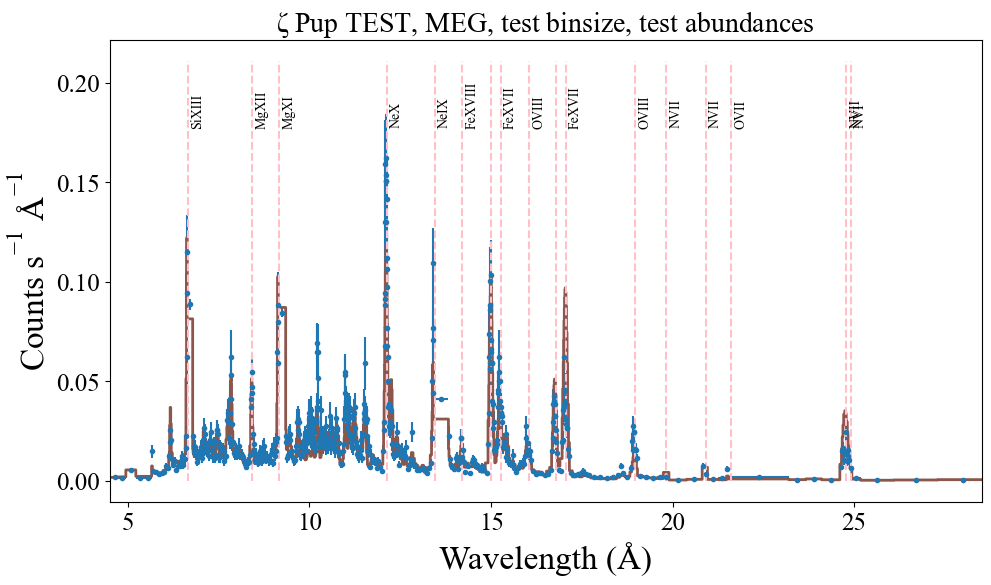

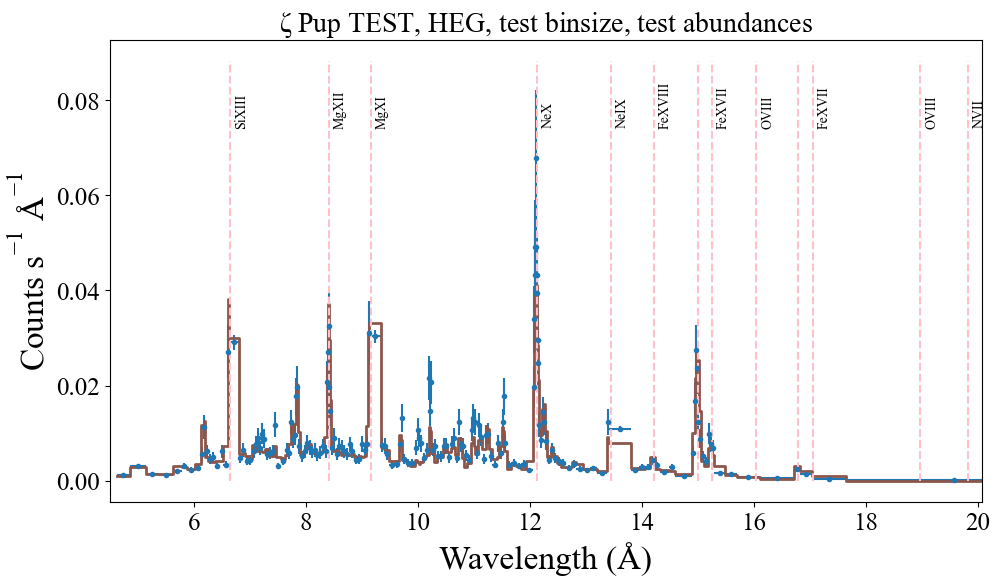

In [177]:
#plotting MEG/RGS1 data
plotspectra(spec1, spec1_wvs, spec1_vals, spec1_bins, spec1_poisson, histwvs[0], histmods[0], spectra1_name)

#plotting #HEG/RGS2 data
plotspectra(spec2, spec2_wvs, spec2_vals, spec2_bins, spec2_poisson, histwvs[1], histmods[1], spectra2_name)